In [1]:
import os
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torchvision
import tifffile as tiff
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from copy import deepcopy
import random


from collections import Counter
from scipy.stats import mode

In [2]:
# Set seed for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set seed
set_seed(42)

In [3]:
# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
full_model_path =  r'C:\Users\k54739\saved_model\simclr_modelepoch250.pth' 

In [5]:
class SimCLR(nn.Module):
    def __init__(self, hidden_dim, lr, temperature, weight_decay):
        super().__init__()
        self.temperature = temperature
        
        # Load the pretrained ResNet-18 model
        self.convnet = torchvision.models.resnet18(weights='ResNet18_Weights.DEFAULT')
        
        # Modify the fully connected layer
        self.convnet.fc = nn.Sequential(
            nn.Linear(self.convnet.fc.in_features, 4 * hidden_dim),  # Linear layer with 4*hidden_dim output
            nn.ReLU(inplace=True),
            nn.Linear(4 * hidden_dim, 20)  # Output layer with hidden_dim output
        )

        self.optimizer = optim.AdamW(self.parameters(), lr=lr, weight_decay=weight_decay)
        self.lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=50, eta_min=lr / 50)

    def forward(self, x):
        return self.convnet(x)

    def info_nce_loss(self, imgs1, imgs2, device):

        imgs = torch.cat((imgs1, imgs2), dim=0)  # Concatenate along the batch dimension
        imgs = imgs.to(device)  # Move images to the device

        # Encode all images
        feats = self.forward(imgs)
    
        # Calculate cosine similarity
        cos_sim = nn.functional.cosine_similarity(feats[:, None, :], feats[None, :, :], dim=-1)
    
        # Mask out cosine similarity to itself
        self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
        cos_sim.masked_fill_(self_mask, -9e15)
    
        # Find positive example -> batch_size//2 away from the original example
        pos_mask = self_mask.roll(shifts=cos_sim.shape[0] // 2, dims=0)
    
        # Normalize similarity scores by temperature
        cos_sim = cos_sim / self.temperature

        # InfoNCE loss
        nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
        nll = nll.mean()

        # Accuracy calculations
        # Create a combination of positive and negative similarities for ranking
        comb_sim = torch.cat([cos_sim[pos_mask][:, None],  # Positive example in first position
                          cos_sim.masked_fill(pos_mask, -9e15)], dim=-1)
    
        # Sort and get the ranking position of the positive example
        sim_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)
    
        # Compute accuracy metrics
        top1_acc = (sim_argsort == 0).float().mean()  # Top-1 accuracy
        top5_acc = (sim_argsort < 5).float().mean()   # Top-5 accuracy
        mean_pos = 1 + sim_argsort.float().mean()     # Mean position of the positive example

        return nll, top1_acc, top5_acc, mean_pos

    def train_epoch(self, train_loader, device):
        self.train()
        total_loss = 0.0
        total_top1_acc = 0.0
        total_top5_acc = 0.0
        total_mean_pos = 0.0

        for batch in tqdm(train_loader, desc="Training", leave=False):
            imgs1, imgs2, _ = batch
            imgs1, imgs2 = imgs1.to(device), imgs2.to(device)  # Move data to device
        
            self.optimizer.zero_grad()

            # Calculate loss and accuracy metrics
            loss, top1_acc, top5_acc, mean_pos = self.info_nce_loss(imgs1, imgs2, device)

            loss.backward()
            self.optimizer.step()
            self.lr_scheduler.step()

            # Accumulate metrics
            total_loss += loss.item()
            total_top1_acc += top1_acc.item()
            total_top5_acc += top5_acc.item()
            total_mean_pos += mean_pos.item()

        avg_loss = total_loss / len(train_loader)
        avg_top1_acc = total_top1_acc / len(train_loader)
        avg_top5_acc = total_top5_acc / len(train_loader)
        avg_mean_pos = total_mean_pos / len(train_loader)

        return avg_loss, avg_top1_acc, avg_top5_acc, avg_mean_pos

    def validate_epoch(self, val_loader, device):
        self.eval()
        total_loss = 0.0
        total_top1_acc = 0.0
        total_top5_acc = 0.0
        total_mean_pos = 0.0

        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validating", leave=False):
                imgs1, imgs2, _ = batch
                imgs1, imgs2 = imgs1.to(device), imgs2.to(device)  # Move data to device

                # Calculate loss and accuracy metrics
                loss, top1_acc, top5_acc, mean_pos = self.info_nce_loss(imgs1, imgs2, device)

                # Accumulate metrics
                total_loss += loss.item()
                total_top1_acc += top1_acc.item()
                total_top5_acc += top5_acc.item()
                total_mean_pos += mean_pos.item()

        avg_loss = total_loss / len(val_loader)
        avg_top1_acc = total_top1_acc / len(val_loader)
        avg_top5_acc = total_top5_acc / len(val_loader)
        avg_mean_pos = total_mean_pos / len(val_loader)

        return avg_loss, avg_top1_acc, avg_top5_acc, avg_mean_pos

In [6]:
# Device setup for inference
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
simclr_model = torch.load(full_model_path)
simclr_model.to(device)
simclr_model.eval()

C:\Users\k54739\AppData\Local\Temp\ipykernel_15704\1117632957.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  simclr_model = torch.load(full_model_path)


SimCLR(
  (convnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

In [8]:
from torchvision.transforms import Resize

# Simclr feature Encoder-decoder


In [9]:
class ImageDataset(Dataset):
    def __init__(self, day7_dir, day10_dir):
        self.day7_files = {os.path.basename(file): os.path.join(day7_dir, file) for file in os.listdir(day7_dir) if file.endswith('.tiff')}
        self.day10_files = {os.path.basename(file): os.path.join(day10_dir, file) for file in os.listdir(day10_dir) if file.endswith('.tiff')}
      
        # Ensure all day7 files have a corresponding day10 file
        self.common_files = list(self.day7_files.keys())
        assert set(self.common_files) <= set(self.day10_files.keys()), "Mismatch between day7 and day10 filenames."
        self.resize = Resize((96, 96))
       

    def __len__(self):
        return len(self.common_files)

    def __getitem__(self, idx):
        filename = self.common_files[idx]
        day7_img_path = self.day7_files[filename]
        day10_img_path = self.day10_files[filename]

        # Load the images
        day7_img = tiff.imread(day7_img_path)
        day10_img = tiff.imread(day10_img_path)

        # Ensure the images have 3 layers (channels)
        if day7_img.shape[0] != 3:
            raise ValueError(f"Day7 image at {day7_img_path} does not have exactly 3 layers. Found shape: {day7_img.shape}.")
        if day10_img.shape[0] != 3:
            raise ValueError(f"Day10 image at {day10_img_path} does not have exactly 3 layers. Found shape: {day10_img.shape}.")

        # Normalize and convert both images
        day7_img = day7_img.astype(np.float32) / 65535.0
        day10_img = day10_img.astype(np.float32) / 65535.0

        # Convert to tensors
        day7_img = torch.tensor(day7_img, dtype=torch.float32)
        day10_img = torch.tensor(day10_img, dtype=torch.float32)

        day7_img = self.resize(day7_img)
        day10_img = self.resize(day10_img)

        return day7_img, day10_img
        #return day7_img, day10_img,day7_img_path,day10_img_path

    
# Specify paths for both day7 and day10 folders
train_day7_dir = r'C:\Users\k54739\Bibi_new_thesis\thesis\day7_day10\control130_all\combined\day7'
train_day10_dir = r'C:\Users\k54739\Bibi_new_thesis\thesis\day7_day10\control130_all\combined\day10'


# Create the dataset
train_dataset = ImageDataset(train_day7_dir, train_day10_dir) 


In [10]:
batch_size = 16
# Define DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False, pin_memory=True, num_workers=0) #num_workers=os.cpu count() using cluster gpu

In [11]:
# Calculate the total number of images in the training dataset
total_images_in_train = len(train_loader.dataset)
print(f"Total number of images: {total_images_in_train}")

Total number of images: 130


In [12]:
# Print the shape of both pairs and total number of images in one epoch
for i, (input_image, target_image) in enumerate(train_loader):
    print(f"Batch {i}:")
    print(f"  Input image (day7): {input_image.shape}")
    print(f"  Target image (day10): {target_image.shape}")
    break

Batch 0:
  Input image (day7): torch.Size([16, 3, 96, 96])
  Target image (day10): torch.Size([16, 3, 96, 96])


# Retrieve one dataset sample
day7_img, day10_img, day7_img_path, day10_img_path = train_dataset[2]

# Convert tensors to numpy arrays for visualization
day7_img_np = day7_img.permute(1, 2, 0).numpy()
day10_img_np = day10_img.permute(1, 2, 0).numpy()

# Display images with paths
plt.figure(figsize=(12, 8))

# Day7 Original
plt.subplot(2, 2, 1)
plt.imshow(day7_img_np)
plt.title(f"Day7 Original\n{day7_img_path}")
plt.axis("off")


# Day10 Original
plt.subplot(2, 2, 3)
plt.imshow(day10_img_np)
plt.title(f"Day10 Original\n{day10_img_path}")
plt.axis("off")


plt.tight_layout()
plt.show()


# Retrieve one dataset sample
day7_img, day10_img, day7_img_path, day10_img_path = val_dataset[2]

# Convert tensors to numpy arrays for visualization
day7_img_np = day7_img.permute(1, 2, 0).numpy()
day10_img_np = day10_img.permute(1, 2, 0).numpy()

# Display images with paths
plt.figure(figsize=(12, 8))

# Day7 Original
plt.subplot(2, 2, 1)
plt.imshow(day7_img_np)
plt.title(f"Day7 Original\n{day7_img_path}")
plt.axis("off")


# Day10 Original
plt.subplot(2, 2, 3)
plt.imshow(day10_img_np)
plt.title(f"Day10 Original\n{day10_img_path}")
plt.axis("off")


plt.tight_layout()
plt.show()


class ImageDataset(Dataset):
    def __init__(self, image_dir):
        self.image_dir = image_dir
        
        # Recursively find all .tiff and .tif files in subdirectories
        self.image_files = []
        for root, _, files in os.walk(image_dir):
            for file in files:
                if file.lower().endswith(('.tiff', '.tif')):
                    self.image_files.append(os.path.join(root, file))
        
        # Debugging: Print the number of images found
        print(f"Found {len(self.image_files)} image files in directory: {image_dir}")
        self.resize_transform = transforms.Resize((96, 96))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Ensure the image has 3 layers (channels)
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} does not have exactly 3 layers.")
        
        # Normalize the 16-bit image to [0, 1]
        image = image.astype(np.float32) / 65535.0
        
        # Convert to a torch tensor
        image = torch.tensor(image, dtype=torch.float32)
        
        # Apply resize transform
        image = self.resize_transform(image)

        return image


# Directories for labeled data
image_dir = r"C:\Users\k54739\Bibi_new_thesis\thesis\control_day7_day10"
dataset = ImageDataset(image_dir=image_dir)

# Define DataLoaders
batch_size = 16
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=False, pin_memory=True, num_workers=0)

In [13]:
@torch.no_grad()
def prepare_data_features(model, dataloader):
    # Prepare model
    network = deepcopy(model.convnet)
    #network.fc = nn.Identity()  # Removing projection head g(.)
    network.eval()
    network.to(device)

    # Encode all paired images
    day7_feats = []
    day10_feats = []
    
    for batch_day7_imgs, batch_day10_imgs in tqdm(dataloader):
        # Move images to the device
        batch_day7_imgs = batch_day7_imgs.to(device)
        batch_day10_imgs = batch_day10_imgs.to(device)

        # Extract features for day7 and day10 images
        batch_day7_feats = network(batch_day7_imgs)
        batch_day10_feats = network(batch_day10_imgs)

        print(f"Day 7 Batch features shape: {batch_day7_feats.shape}")
        print(f"Day 10 Batch features shape: {batch_day10_feats.shape}")

        # Collect features
        day7_feats.append(batch_day7_feats.detach().cpu())
        day10_feats.append(batch_day10_feats.detach().cpu())

    # Concatenate features
    day7_feats = torch.cat(day7_feats, dim=0)
    day10_feats = torch.cat(day10_feats, dim=0)

    print(f"Day 7 Features shape after concatenation: {day7_feats.shape}")
    print(f"Day 10 Features shape after concatenation: {day10_feats.shape}")

    return day7_feats, day10_feats


In [14]:
# Assuming you have a pre-trained model and DataLoader
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Extract features from the training dataset
controlall_day7, controlall_day10 = prepare_data_features(simclr_model, train_loader)


# Use the extracted features for your MLP model training
# Example: MLP(input_dim=train_day7_feats.shape[1], output_dim=train_day10_feats.shape[1])


 11%|█         | 1/9 [00:01<00:13,  1.72s/it]

Day 7 Batch features shape: torch.Size([16, 20])
Day 10 Batch features shape: torch.Size([16, 20])


 22%|██▏       | 2/9 [00:03<00:10,  1.56s/it]

Day 7 Batch features shape: torch.Size([16, 20])
Day 10 Batch features shape: torch.Size([16, 20])


 33%|███▎      | 3/9 [00:04<00:08,  1.50s/it]

Day 7 Batch features shape: torch.Size([16, 20])
Day 10 Batch features shape: torch.Size([16, 20])


 44%|████▍     | 4/9 [00:06<00:07,  1.48s/it]

Day 7 Batch features shape: torch.Size([16, 20])
Day 10 Batch features shape: torch.Size([16, 20])


 56%|█████▌    | 5/9 [00:07<00:05,  1.48s/it]

Day 7 Batch features shape: torch.Size([16, 20])
Day 10 Batch features shape: torch.Size([16, 20])


 67%|██████▋   | 6/9 [00:08<00:04,  1.47s/it]

Day 7 Batch features shape: torch.Size([16, 20])
Day 10 Batch features shape: torch.Size([16, 20])


 78%|███████▊  | 7/9 [00:10<00:02,  1.44s/it]

Day 7 Batch features shape: torch.Size([16, 20])
Day 10 Batch features shape: torch.Size([16, 20])
Day 7 Batch features shape: torch.Size([16, 20])
Day 10 Batch features shape: torch.Size([16, 20])


100%|██████████| 9/9 [00:12<00:00,  1.35s/it]

Day 7 Batch features shape: torch.Size([2, 20])
Day 10 Batch features shape: torch.Size([2, 20])
Day 7 Features shape after concatenation: torch.Size([130, 20])
Day 10 Features shape after concatenation: torch.Size([130, 20])


In [15]:
save_dir = r"C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\Ranking(prediction)_model\resizeonly_feats\after"

torch.save(controlall_day7, os.path.join(save_dir, 'controlall_day7.pt'))
torch.save(controlall_day10, os.path.join(save_dir, 'controlall_day10.pt'))

print("Features saved successfully!")


Features saved successfully!


# Save training features
torch.save(train_day7_feats, 'train_day7_feats.pt')
torch.save(train_day10_feats, 'train_day10_feats.pt')

print("Features saved successfully!")


In [1]:
import os
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torchvision

In [2]:
# Load training features
exploded40_day7 = torch.load('exploded40_day7.pt')
exploded40_day10 = torch.load('exploded40_day10.pt')


C:\Users\k54739\AppData\Local\Temp\ipykernel_5728\2674064639.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  exploded40_day7 = torch.load('exploded40_day7.pt')
C:\Users\

In [3]:
# Print lengths of feature tensors
print(f"Number of training Day 7 features: {len(exploded40_day7)}")
print(f"Number of training Day 10 features: {len(exploded40_day10)}")


Number of training Day 7 features: 40
Number of training Day 10 features: 40


In [4]:
# Print shapes of feature tensors
print(f"Shape of training Day 7 features: {exploded40_day7.shape}")
print(f"Shape of training Day 10 features: {exploded40_day10.shape}")


Shape of training Day 7 features: torch.Size([40, 512])
Shape of training Day 10 features: torch.Size([40, 512])


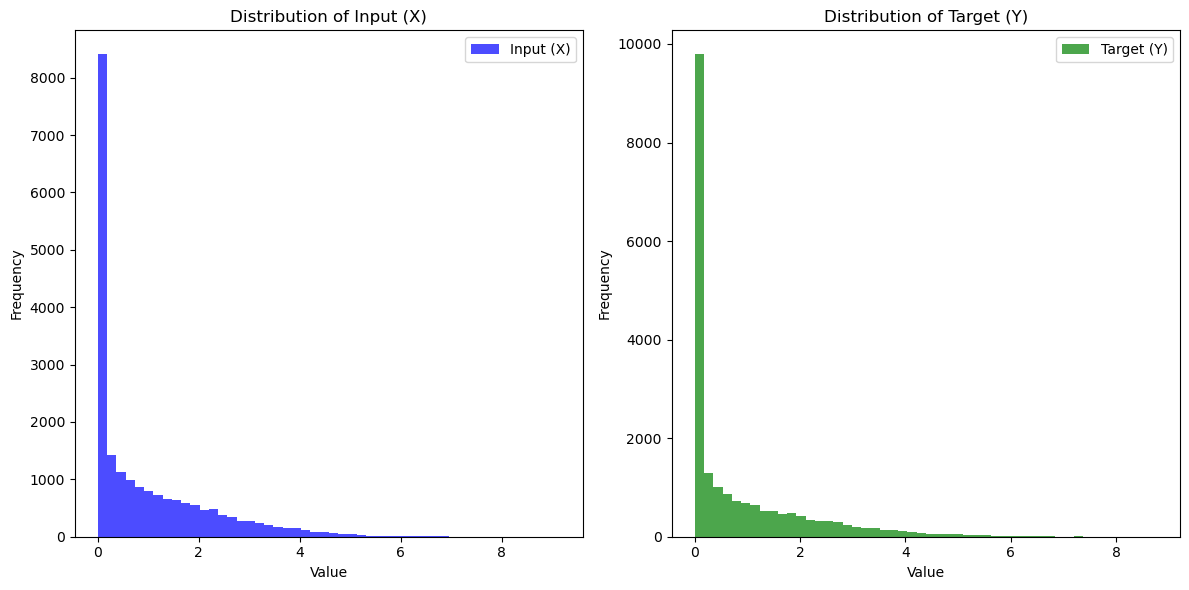

Input (X): Mean=0.9550, Std=1.2049
Target (Y): Mean=0.8566, Std=1.2297


In [5]:
import matplotlib.pyplot as plt

# Plot histograms for input (X) and target (Y)
plt.figure(figsize=(12, 6))

# Flatten tensors to 1D for easier visualization
exploded40_day7_flat = exploded40_day7.flatten().cpu().numpy()
exploded40_day10_flat = exploded40_day10.flatten().cpu().numpy()

# Input (X) histogram
plt.subplot(1, 2, 1)
plt.hist(exploded40_day7_flat, bins=50, color='blue', alpha=0.7, label='Input (X)')
plt.title('Distribution of Input (X)')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()

# Target (Y) histogram
plt.subplot(1, 2, 2)
plt.hist(exploded40_day10_flat, bins=50, color='green', alpha=0.7, label='Target (Y)')
plt.title('Distribution of Target (Y)')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"Input (X): Mean={exploded40_day7.mean():.4f}, Std={exploded40_day7.std():.4f}")
print(f"Target (Y): Mean={exploded40_day10.mean():.4f}, Std={exploded40_day10.std():.4f}")


In [1]:
# Min-Max Scaling for Input (X) and Target (Y)
def min_max_scaling(data):
    data_min = data.min()
    data_max = data.max()
    return (data - data_min) / (data_max - data_min), data_min, data_max  # Return scaled data and min/max for inverse scaling

# Apply Min-Max Scaling
exploded40_day7_minmaxed, day7_min, day7_max = min_max_scaling(exploded40_day7)
exploded40_day10_minmaxed, day10_min, day10_max = min_max_scaling(exploded40_day10)

# Print summary to confirm
print("After Min-Max Scaling:")
print(f"Input (X): Min={exploded40_day7_minmaxed.min():.4f}, Max={exploded40_day7_minmaxed.max():.4f}")
print(f"Target (Y): Min={exploded40_day10_minmaxed.min():.4f}, Max={exploded40_day10_minmaxed.max():.4f}")



NameError: name 'exploded40_day7' is not defined

In [7]:
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

class FeaturePredictor(nn.Module):
    def __init__(self, input_size=512, output_size=512):
        super(FeaturePredictor, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16,8),
            nn.ReLU(),
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.Linear(16,32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128,256),
            nn.ReLU(),
            nn.Linear(256, output_size)
        )
    
    def forward(self, x):
        return self.model(x)

In [8]:
# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Define the directory where models are saved
load_dir = r'C:\Users\k54739\saved_model\ranking\simclr\minmax_scaled'

# Load a specific fold's best model
model = FeaturePredictor()
load_path = os.path.join(load_dir, 'best_model_fold_5.pth')
model.load_state_dict(torch.load(load_path))
model.to(device)
model.eval()

print(f"Loaded model from {load_path}")


C:\Users\k54739\AppData\Local\Temp\ipykernel_5728\187304485.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(load_path))


Loaded model from C:\Users\k54739\saved_model\ranking\simclr\minmax_scaled\best_model_fold_5.pth


torch.Size([40, 512])


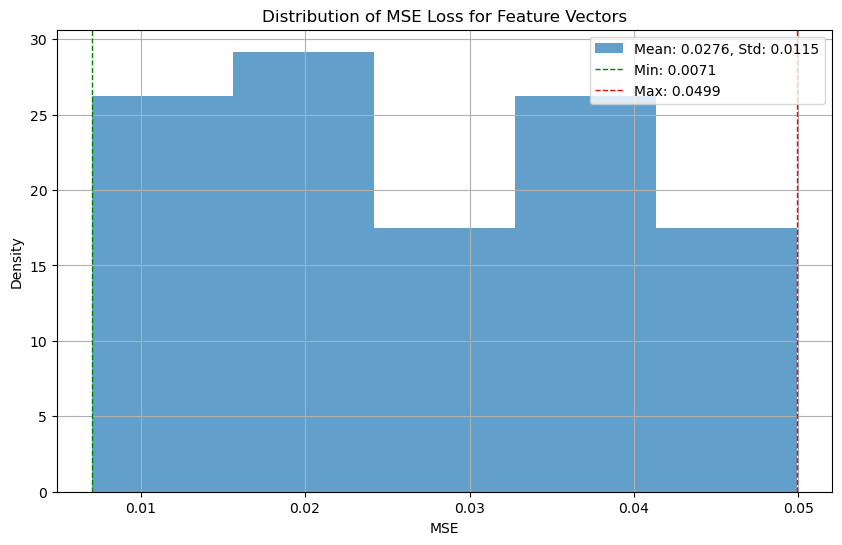

In [9]:
import torch
import matplotlib.pyplot as plt
import torch.nn as nn


with torch.no_grad():
        exploded40_day7_minmaxed = exploded40_day7_minmaxed.to(device)
        exploded40_day10_minmaxed = exploded40_day10_minmaxed.to(device)

        predicted_day10 = model(exploded40_day7_minmaxed)

print(predicted_day10.shape)

# Initialize the MSE loss function
mse_loss_fn = nn.MSELoss(reduction='none')  # 'none' to get element-wise loss

# Compute the per-feature-vector MSE
mse_per_vector = mse_loss_fn(exploded40_day10_minmaxed, predicted_day10).mean(dim=1)  # Mean over feature dimension (512)

# Convert MSE values to a list for plotting
mse_values = mse_per_vector.cpu().numpy()

# Calculate statistics
mean_mse = mse_per_vector.mean().item()
std_mse = mse_per_vector.std().item()
min_mse = mse_per_vector.min().item()
max_mse = mse_per_vector.max().item()


# Plot the distribution of MSE values
plt.figure(figsize=(10, 6))
plt.hist(mse_values, bins=5, alpha=0.7, density=True, label=f"Mean: {mean_mse:.4f}, Std: {std_mse:.4f}")

# Add vertical lines for min and max
plt.axvline(min_mse, color='green', linestyle='--', linewidth=1, label=f"Min: {min_mse:.4f}")
plt.axvline(max_mse, color='red', linestyle='--', linewidth=1, label=f"Max: {max_mse:.4f}")

plt.title('Distribution of MSE Loss for Feature Vectors')
plt.xlabel('MSE')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()



torch.Size([40, 512])
MSE Loss Distribution - Mean: 0.0276, Std: 0.0114, Min: 0.0071, Max: 0.0499


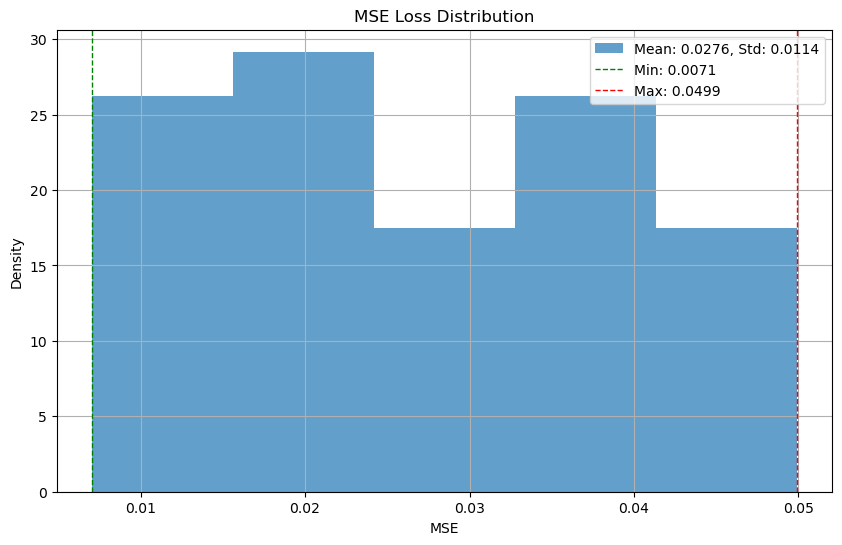

Euclidean Distance Distribution - Mean: 3.6734, Std: 0.7995, Min: 1.9002, Max: 5.0550


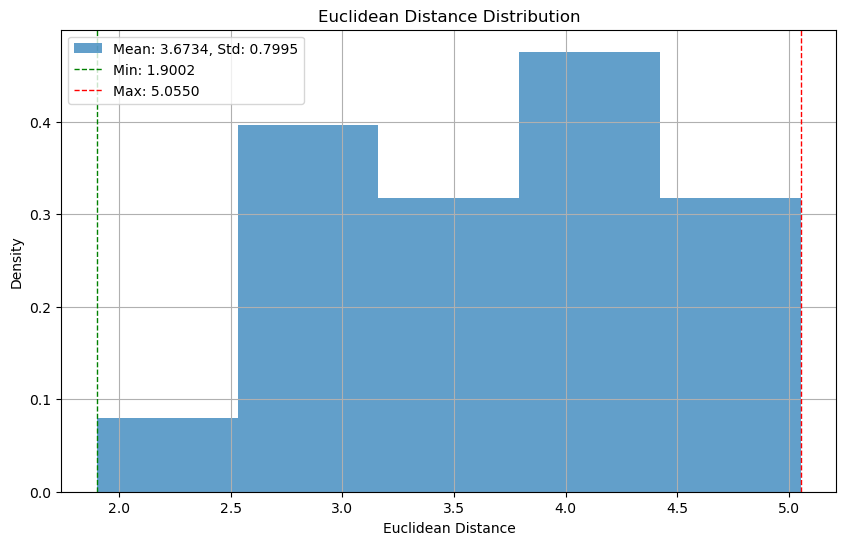

Cosine Distance Distribution - Mean: 0.4913, Std: 0.1022, Min: 0.1948, Max: 0.6801


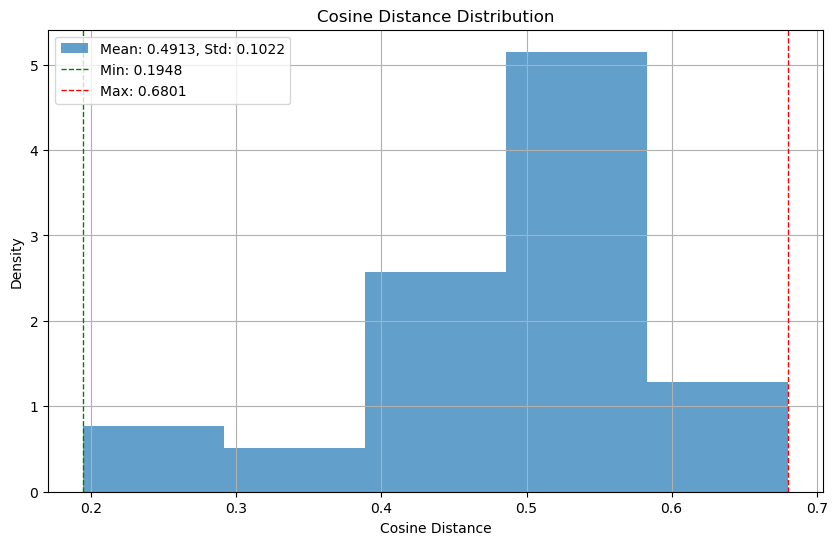

In [16]:
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

# Assume exploded40_day7_minmaxed and exploded40_day10_minmaxed are already loaded and processed
with torch.no_grad():
    exploded40_day7_minmaxed = exploded40_day7_minmaxed.to(device)
    exploded40_day10_minmaxed = exploded40_day10_minmaxed.to(device)

    predicted_day10 = model(exploded40_day7_minmaxed)

print(predicted_day10.shape)

# Initialize the MSE loss function
mse_loss_fn = nn.MSELoss(reduction='none')  # 'none' to get element-wise loss

# Calculate metrics
# MSE loss
mse_per_vector = mse_loss_fn(exploded40_day10_minmaxed, predicted_day10).mean(dim=1)  # Mean over feature dimension (512)
mse_values = mse_per_vector.cpu().numpy()

# Euclidean distance
euclidean_distances = torch.norm(predicted_day10 - exploded40_day10_minmaxed, dim=1, p=2).cpu().numpy()

# Cosine distance (1 - cosine similarity)
cosine_distances = (1 - F.cosine_similarity(predicted_day10, exploded40_day10_minmaxed, dim=1)).cpu().numpy()

# Function to calculate statistics and plot distributions
def plot_distribution(values, title, xlabel, bins=5, color='blue'):
    mean_val = values.mean()
    std_val = values.std()
    min_val = values.min()
    max_val = values.max()
    
    print(f"{title} - Mean: {mean_val:.4f}, Std: {std_val:.4f}, Min: {min_val:.4f}, Max: {max_val:.4f}")
    
    plt.figure(figsize=(10, 6))
    plt.hist(values, bins=bins, alpha=0.7, density=True, label=f"Mean: {mean_val:.4f}, Std: {std_val:.4f}")
    plt.axvline(min_val, color='green', linestyle='--', linewidth=1, label=f"Min: {min_val:.4f}")
    plt.axvline(max_val, color='red', linestyle='--', linewidth=1, label=f"Max: {max_val:.4f}")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot the distributions
plot_distribution(mse_values, "MSE Loss Distribution", "MSE")
plot_distribution(euclidean_distances, "Euclidean Distance Distribution", "Euclidean Distance")
plot_distribution(cosine_distances, "Cosine Distance Distribution", "Cosine Distance")


Mean MSE: 0.0276, Standard Deviation: 0.0115
Min MSE: 0.0071, Max MSE: 0.0499


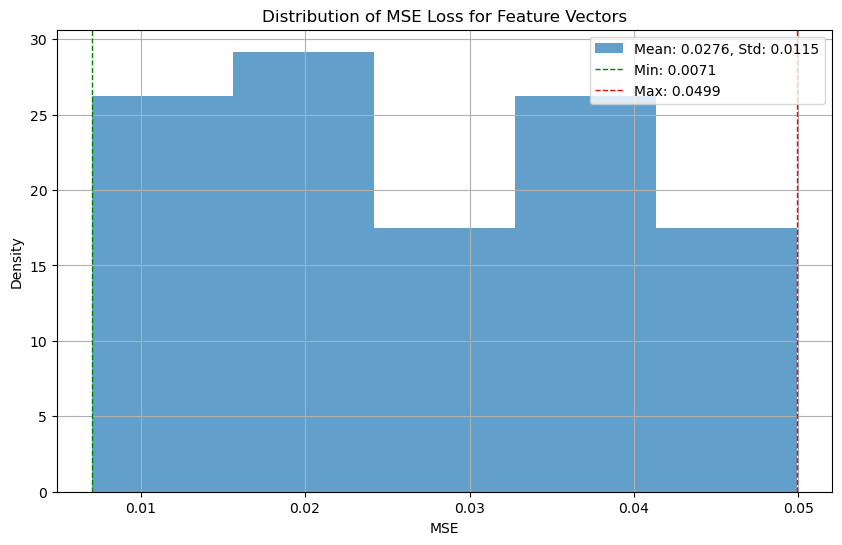

In [14]:
import torch
import matplotlib.pyplot as plt
import torch.nn as nn

# Assume train_day7_feats_minmaxed and train_day10_feats_minmaxed are already loaded
# Example shapes: [130, 512]

# Ensure the tensors are on the same device as the model
exploded40_day7_minmaxed = exploded40_day7_minmaxed.to(device)
exploded40_day10_minmaxed = exploded40_day10_minmaxed.to(device)

# Initialize the MSE loss function
mse_loss_fn = nn.MSELoss()

# List to store MSE for each feature vector
mse_values = []

# Loop through each feature vector
for i in range(exploded40_day7_minmaxed.shape[0]):
    exploded40_day7 = exploded40_day7_minmaxed[i].unsqueeze(0)  # Shape: [1, 512]
    exploded40_day10 = exploded40_day10_minmaxed[i].unsqueeze(0)  # Shape: [1, 512]
    
    # Get prediction
    with torch.no_grad():
        predicted_day10 = model(exploded40_day7)
    
    # Compute MSE for this feature vector
    mse = mse_loss_fn(predicted_day10, exploded40_day10).item()
    mse_values.append(mse)

# Convert MSE values to a tensor for statistical calculations
mse_values_tensor = torch.tensor(mse_values)

# Calculate mean and standard deviation
mean_mse = mse_values_tensor.mean().item()
std_mse = mse_values_tensor.std().item()
min_mse = mse_values_tensor.min().item()
max_mse = mse_values_tensor.max().item()

print(f"Mean MSE: {mean_mse:.4f}, Standard Deviation: {std_mse:.4f}")
print(f"Min MSE: {min_mse:.4f}, Max MSE: {max_mse:.4f}")

# Plot the distribution of MSE values
plt.figure(figsize=(10, 6))
plt.hist(mse_values, bins=5, alpha=0.7, density=True, label=f"Mean: {mean_mse:.4f}, Std: {std_mse:.4f}")

# Add vertical lines for min and max values
plt.axvline(min_mse, color='green', linestyle='--', linewidth=1, label=f"Min: {min_mse:.4f}")
plt.axvline(max_mse, color='red', linestyle='--', linewidth=1, label=f"Max: {max_mse:.4f}")

plt.title('Distribution of MSE Loss for Feature Vectors')
plt.xlabel('MSE')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()


MSE Loss Distribution - Mean: 0.0276, Std: 0.0115, Min: 0.0071, Max: 0.0499


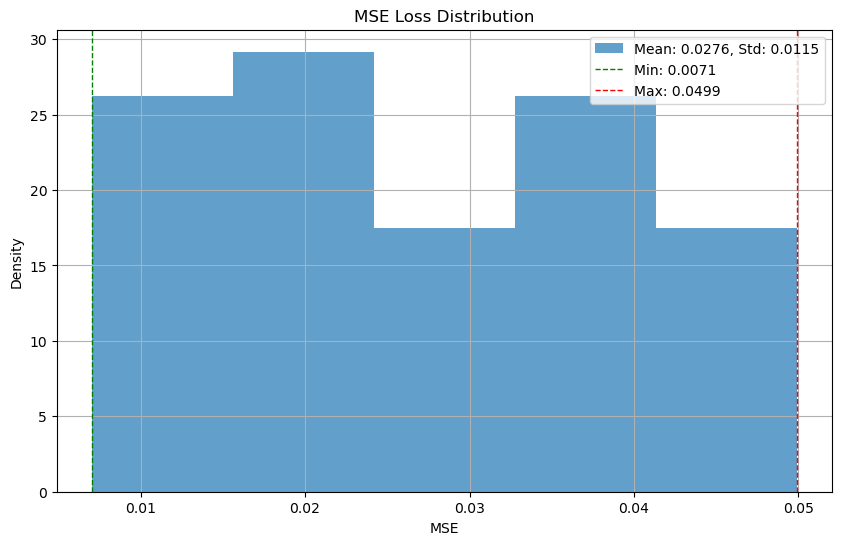

Euclidean Distance Distribution - Mean: 3.6734, Std: 0.8097, Min: 1.9002, Max: 5.0550


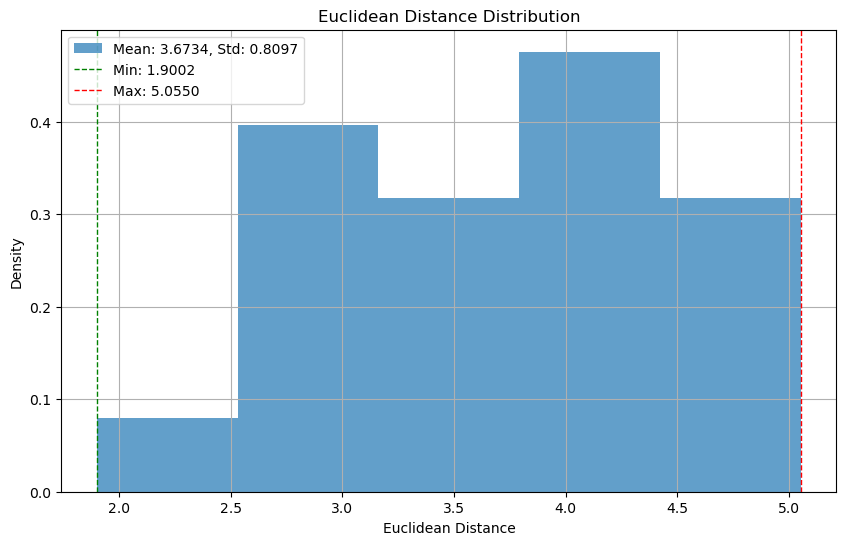

Cosine Distance Distribution - Mean: 0.4913, Std: 0.1035, Min: 0.1948, Max: 0.6801


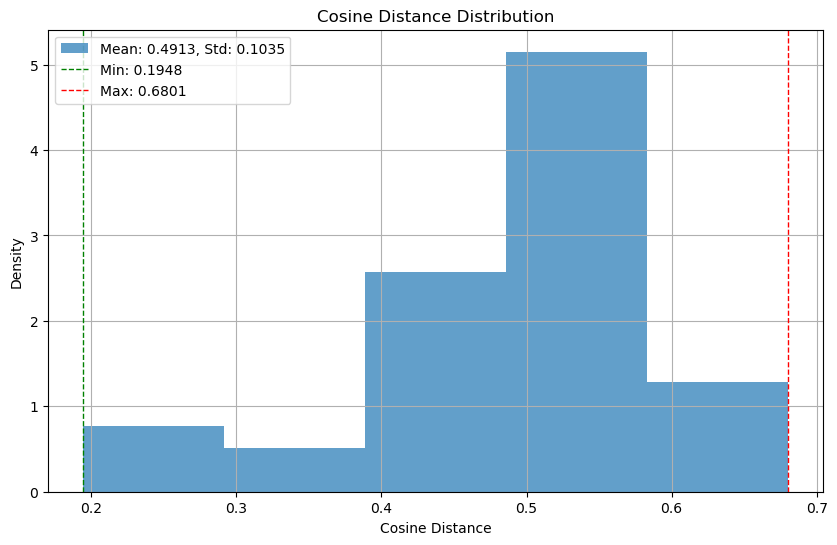

In [15]:
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

# Assume exploded40_day7_minmaxed and exploded40_day10_minmaxed are already loaded
# Example shapes: [N, 512], where N is the number of feature vectors

# Ensure the tensors are on the same device as the model
exploded40_day7_minmaxed = exploded40_day7_minmaxed.to(device)
exploded40_day10_minmaxed = exploded40_day10_minmaxed.to(device)

# Initialize the MSE loss function
mse_loss_fn = nn.MSELoss()

# Lists to store metrics for each feature vector
mse_values = []
euclidean_distances = []
cosine_distances = []

# Loop through each feature vector
for i in range(exploded40_day7_minmaxed.shape[0]):
    exploded40_day7 = exploded40_day7_minmaxed[i].unsqueeze(0)  # Shape: [1, 512]
    exploded40_day10 = exploded40_day10_minmaxed[i].unsqueeze(0)  # Shape: [1, 512]
    
    # Get prediction
    with torch.no_grad():
        predicted_day10 = model(exploded40_day7)
    
    # Compute MSE for this feature vector
    mse = mse_loss_fn(predicted_day10, exploded40_day10).item()
    mse_values.append(mse)
    
    # Compute Euclidean distance
    euclidean_distance = torch.norm(predicted_day10 - exploded40_day10, p=2).item()
    euclidean_distances.append(euclidean_distance)
    
    # Compute Cosine distance
    cosine_distance = 1 - F.cosine_similarity(predicted_day10, exploded40_day10, dim=1).item()
    cosine_distances.append(cosine_distance)

# Convert metrics to tensors for statistical calculations
mse_values_tensor = torch.tensor(mse_values)
euclidean_distances_tensor = torch.tensor(euclidean_distances)
cosine_distances_tensor = torch.tensor(cosine_distances)

# Function to calculate and plot the distribution
def plot_distribution(values, title, xlabel, bins=5, color='blue'):
    mean_val = values.mean().item()
    std_val = values.std().item()
    min_val = values.min().item()
    max_val = values.max().item()
    
    print(f"{title} - Mean: {mean_val:.4f}, Std: {std_val:.4f}, Min: {min_val:.4f}, Max: {max_val:.4f}")
    
    plt.figure(figsize=(10, 6))
    plt.hist(values.cpu().numpy(), bins=bins, alpha=0.7, density=True, label=f"Mean: {mean_val:.4f}, Std: {std_val:.4f}")
    plt.axvline(min_val, color='green', linestyle='--', linewidth=1, label=f"Min: {min_val:.4f}")
    plt.axvline(max_val, color='red', linestyle='--', linewidth=1, label=f"Max: {max_val:.4f}")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot the distributions
plot_distribution(mse_values_tensor, "MSE Loss Distribution", "MSE")
plot_distribution(euclidean_distances_tensor, "Euclidean Distance Distribution", "Euclidean Distance")
plot_distribution(cosine_distances_tensor, "Cosine Distance Distribution", "Cosine Distance")


In [ ]:
# Load training features
control29_day7 = torch.load('control29_day7.pt')
control29_day10 = torch.load('control29_day10.pt')


In [3]:
# Print lengths of feature tensors
print(f"Number of training Day 7 features: {len(control29_day7)}")
print(f"Number of training Day 10 features: {len(control29_day10)}")


Number of training Day 7 features: 29
Number of training Day 10 features: 29


In [6]:
# Print shapes of feature tensors
print(f"Shape of training Day 7 features: {control29_day7.shape}")
print(f"Shape of training Day 10 features: {control29_day10.shape}")


Shape of training Day 7 features: torch.Size([29, 512])
Shape of training Day 10 features: torch.Size([29, 512])


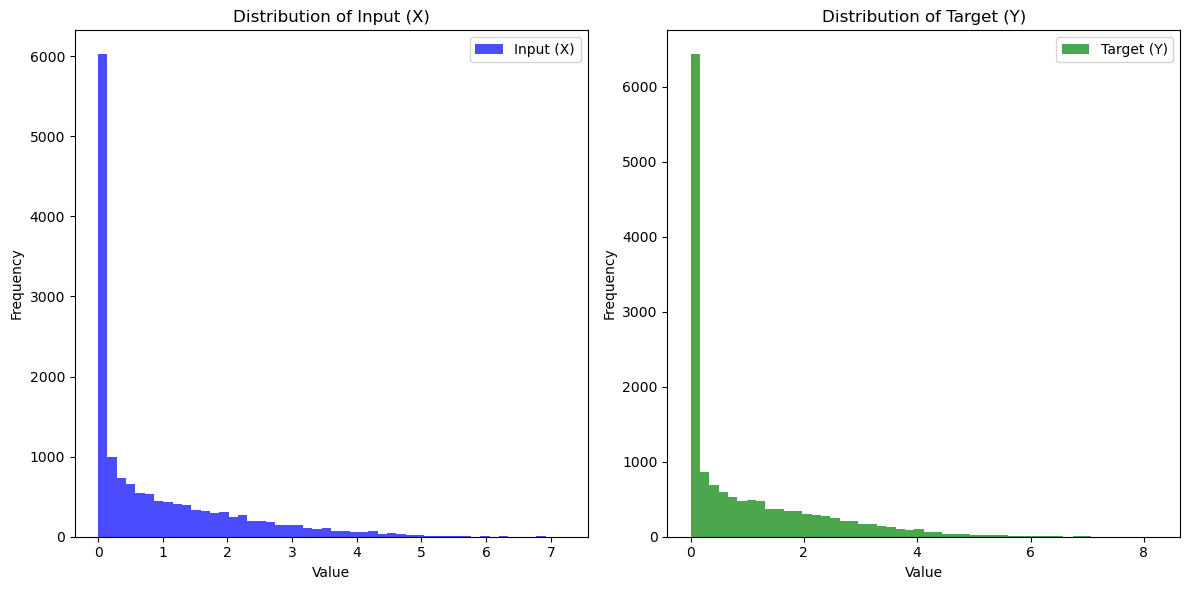

Input (X): Mean=0.8859, Std=1.1473
Target (Y): Mean=0.9528, Std=1.2515


In [7]:
import matplotlib.pyplot as plt

# Plot histograms for input (X) and target (Y)
plt.figure(figsize=(12, 6))

# Flatten tensors to 1D for easier visualization
control29_day7_flat = control29_day7.flatten().cpu().numpy()
control29_day10_flat = control29_day10.flatten().cpu().numpy()

# Input (X) histogram
plt.subplot(1, 2, 1)
plt.hist(control29_day7_flat, bins=50, color='blue', alpha=0.7, label='Input (X)')
plt.title('Distribution of Input (X)')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()

# Target (Y) histogram
plt.subplot(1, 2, 2)
plt.hist(control29_day10_flat, bins=50, color='green', alpha=0.7, label='Target (Y)')
plt.title('Distribution of Target (Y)')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"Input (X): Mean={control29_day7.mean():.4f}, Std={control29_day7.std():.4f}")
print(f"Target (Y): Mean={control29_day10.mean():.4f}, Std={control29_day10.std():.4f}")


In [ ]:
# orig distribution

# Single dose
# Input (X): Mean=0.8487, Std=1.1187
# Target (Y): Mean=0.9356, Std=1.2985

# control29
# Input (X): Mean=0.8859, Std=1.1473
# Target (Y): Mean=0.9528, Std=1.2515


In [8]:
# Min-Max Scaling for Input (X) and Target (Y)
control29_day7_min = control29_day7.min()
control29_day7_max = control29_day7.max()
print(control29_day7_min,control29_day7_max)
train_day7_feats_scaled = (control29_day7 - control29_day7_min) / (control29_day7_max - control29_day7_min)

control29_day10_min = control29_day10.min()
control29_day10_max = control29_day10.max()
print(control29_day10_min,control29_day10_max)
train_day10_feats_scaled = (control29_day10 - control29_day10_min) / (control29_day10_max - control29_day10_min)


tensor(0.) tensor(7.2069)
tensor(0.) tensor(8.2259)


In [ ]:
# inference sd
# inference_sd_day7_min,inference_sd_day7_max = tensor(0.) tensor(6.5900)
# inference_sd_day10_min,inference_sd_day10_max = tensor(0.) tensor(11.7951)

In [9]:
# Min-Max Scaling for Input (X) and Target (Y)
def min_max_scaling(data):
    data_min = data.min()
    data_max = data.max()
    return (data - data_min) / (data_max - data_min), data_min, data_max  # Return scaled data and min/max for inverse scaling

# Apply Min-Max Scaling
control29_day7_minmaxed, day7_min, day7_max = min_max_scaling(control29_day7)
control29_day10_minmaxed, day10_min, day10_max = min_max_scaling(control29_day10)

# Print summary to confirm
print("After Min-Max Scaling:")
print(f"Input (X): Min={control29_day7_minmaxed.min():.4f}, Max={control29_day7_minmaxed.max():.4f}")
print(f"Target (Y): Min={control29_day10_minmaxed.min():.4f}, Max={control29_day10_minmaxed.max():.4f}")



After Min-Max Scaling:
Input (X): Min=0.0000, Max=1.0000
Target (Y): Min=0.0000, Max=1.0000


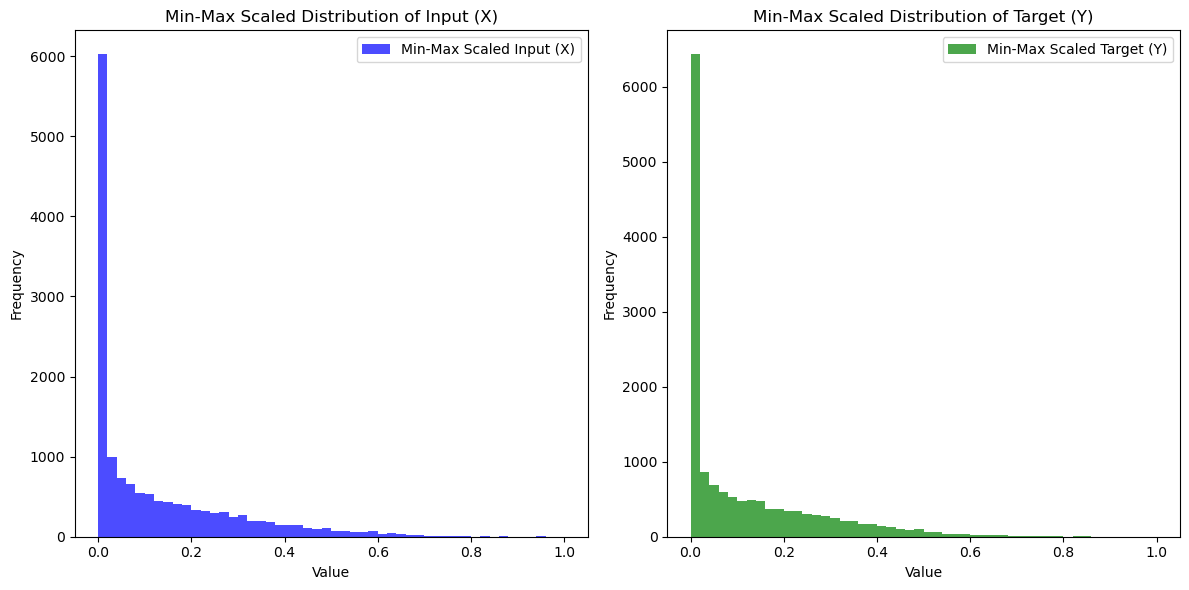

In [10]:
import matplotlib.pyplot as plt

# Flatten the tensors for easier visualization
control29_day7_minmaxed_flat = control29_day7_minmaxed.flatten().cpu().numpy()
control29_day10_minmaxed_flat = control29_day10_minmaxed.flatten().cpu().numpy()

# Plot histograms
plt.figure(figsize=(12, 6))

# Input (X) histogram after Min-Max scaling
plt.subplot(1, 2, 1)
plt.hist(control29_day7_minmaxed_flat, bins=50, color='blue', alpha=0.7, label='Min-Max Scaled Input (X)')
plt.title('Min-Max Scaled Distribution of Input (X)')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()

# Target (Y) histogram after Min-Max scaling
plt.subplot(1, 2, 2)
plt.hist(control29_day10_minmaxed_flat, bins=50, color='green', alpha=0.7, label='Min-Max Scaled Target (Y)')
plt.title('Min-Max Scaled Distribution of Target (Y)')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()


In [11]:
from scipy.stats import boxcox
import torch

# Flatten the data and apply Box-Cox (Box-Cox requires positive values)
control29_day7_flat = control29_day7.flatten().cpu().numpy() + 1e-6  # Add small constant to avoid zero
control29_day10_flat = control29_day10.flatten().cpu().numpy() + 1e-6

control29_day7_boxcox, lambda_7 = boxcox(control29_day7_flat)
control29_day10_boxcox, lambda_10 = boxcox(control29_day10_flat)

print(f"Box-Cox Lambda for Input (X): {lambda_7}")
print(f"Box-Cox Lambda for Target (Y): {lambda_10}")


Box-Cox Lambda for Input (X): 0.1493379534526844
Box-Cox Lambda for Target (Y): 0.12748067757085635


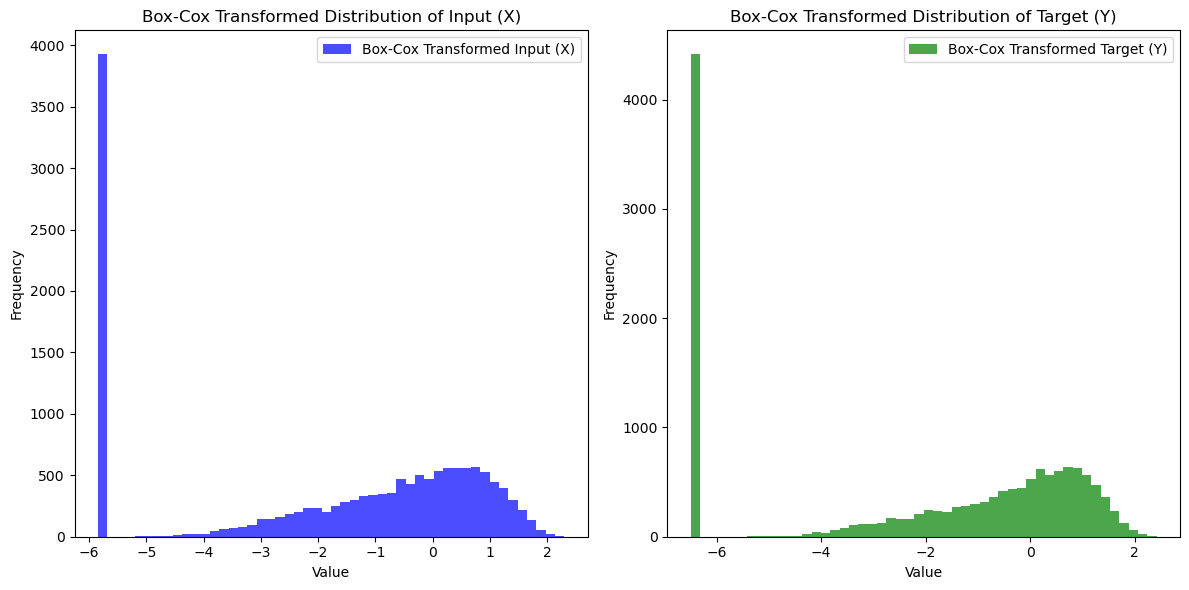

In [12]:
# Plot histograms after Box-Cox transformation
plt.figure(figsize=(12, 6))

# Input (X)
plt.subplot(1, 2, 1)
plt.hist(control29_day7_boxcox, bins=50, color='blue', alpha=0.7, label='Box-Cox Transformed Input (X)')
plt.title('Box-Cox Transformed Distribution of Input (X)')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()

# Target (Y)
plt.subplot(1, 2, 2)
plt.hist(control29_day10_boxcox, bins=50, color='green', alpha=0.7, label='Box-Cox Transformed Target (Y)')
plt.title('Box-Cox Transformed Distribution of Target (Y)')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()


In [1]:
import os
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torchvision

In [2]:
# Load training features
inference_sd_day7 = torch.load('inference_sd_day7.pt')
inference_sd_day10 = torch.load('inference_sd_day10.pt')


C:\Users\k54739\AppData\Local\Temp\ipykernel_8780\414216957.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  inference_sd_day7 = torch.load('inference_sd_day7.pt')
C:\Use

In [3]:
inference_sd_day7

tensor([[0.0000, 0.0000, 1.1177,  ..., 4.7554, 0.0000, 1.2192],
        [1.5634, 0.0768, 0.0073,  ..., 2.1748, 0.9543, 2.6965],
        [0.3505, 0.1033, 0.0952,  ..., 2.0586, 0.0000, 0.9589],
        ...,
        [1.0277, 0.0124, 0.1167,  ..., 3.5348, 0.0294, 2.4753],
        [0.0000, 0.0000, 0.8155,  ..., 2.2120, 0.0000, 0.0000],
        [1.7956, 0.0471, 0.0369,  ..., 2.6556, 0.4420, 3.8215]])

In [4]:
inference_sd_day10

tensor([[2.3463e+00, 0.0000e+00, 0.0000e+00,  ..., 4.3236e-01, 0.0000e+00,
         7.5951e-01],
        [1.8805e+00, 8.1934e-01, 4.6434e-02,  ..., 1.2804e-01, 0.0000e+00,
         3.9649e-01],
        [0.0000e+00, 1.9232e-01, 7.9683e-01,  ..., 6.2674e-02, 0.0000e+00,
         0.0000e+00],
        ...,
        [3.2696e+00, 1.6963e+00, 0.0000e+00,  ..., 1.3728e+00, 3.9278e-03,
         1.7484e+00],
        [4.5861e+00, 0.0000e+00, 0.0000e+00,  ..., 1.0434e+00, 0.0000e+00,
         2.1944e+00],
        [0.0000e+00, 7.1825e-01, 3.9650e-01,  ..., 1.1747e-01, 0.0000e+00,
         0.0000e+00]])

In [5]:
# Print lengths of feature tensors
print(f"Number of training Day 7 features: {len(inference_sd_day7)}")
print(f"Number of training Day 10 features: {len(inference_sd_day10)}")


Number of training Day 7 features: 29
Number of training Day 10 features: 29


In [6]:
# Print shapes of feature tensors
print(f"Shape of training Day 7 features: {inference_sd_day7.shape}")
print(f"Shape of training Day 10 features: {inference_sd_day10.shape}")


Shape of training Day 7 features: torch.Size([29, 512])
Shape of training Day 10 features: torch.Size([29, 512])


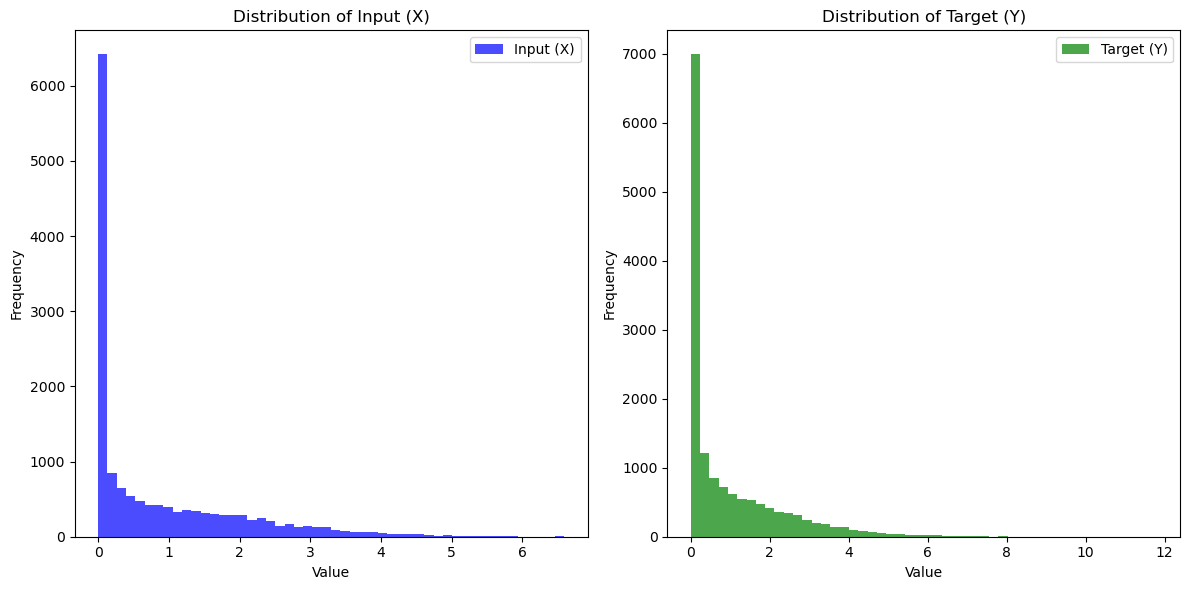

Input (X): Mean=0.8487, Std=1.1187
Target (Y): Mean=0.9356, Std=1.2985


In [7]:
import matplotlib.pyplot as plt

# Plot histograms for input (X) and target (Y)
plt.figure(figsize=(12, 6))

# Flatten tensors to 1D for easier visualization
inference_sd_day7_flat = inference_sd_day7.flatten().cpu().numpy()
inference_sd_day10_flat = inference_sd_day10.flatten().cpu().numpy()

# Input (X) histogram
plt.subplot(1, 2, 1)
plt.hist(inference_sd_day7_flat, bins=50, color='blue', alpha=0.7, label='Input (X)')
plt.title('Distribution of Input (X)')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()

# Target (Y) histogram
plt.subplot(1, 2, 2)
plt.hist(inference_sd_day10_flat, bins=50, color='green', alpha=0.7, label='Target (Y)')
plt.title('Distribution of Target (Y)')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"Input (X): Mean={inference_sd_day7.mean():.4f}, Std={inference_sd_day7.std():.4f}")
print(f"Target (Y): Mean={inference_sd_day10.mean():.4f}, Std={inference_sd_day10.std():.4f}")


In [8]:
# orig distribution

# Single dose
# Input (X): Mean=0.8487, Std=1.1187
# Target (Y): Mean=0.9356, Std=1.2985

# control
# Input (X): Mean=0.9220, Std=1.1895
# Target (Y): Mean=0.9411, Std=1.2415


In [9]:
# Min-Max Scaling for Input (X) and Target (Y)
inference_sd_day7_min = inference_sd_day7.min()
inference_sd_day7_max = inference_sd_day7.max()
print(inference_sd_day7_min,inference_sd_day7_max)
train_day7_feats_scaled = (inference_sd_day7 - inference_sd_day7_min) / (inference_sd_day7_max - inference_sd_day7_min)

inference_sd_day10_min = inference_sd_day10.min()
inference_sd_day10_max = inference_sd_day10.max()
print(inference_sd_day10_min,inference_sd_day10_max)
train_day10_feats_scaled = (inference_sd_day10 - inference_sd_day10_min) / (inference_sd_day10_max - inference_sd_day10_min)


tensor(0.) tensor(6.5900)
tensor(0.) tensor(11.7951)


In [10]:
# inference sd
# inference_sd_day7_min,inference_sd_day7_max = tensor(0.) tensor(6.5900)
# inference_sd_day10_min,inference_sd_day10_max = tensor(0.) tensor(11.7951)

#control

# control_day7_min, control_day7_max  = tensor(0.) tensor(9.1844)
# control_day10_min, control_day10_max = tensor(0.) tensor(9.1225)


In [8]:
# Min-Max Scaling for Input (X) and Target (Y)
def min_max_scaling(data):
    data_min = data.min()
    data_max = data.max()
    return (data - data_min) / (data_max - data_min), data_min, data_max  # Return scaled data and min/max for inverse scaling

# Apply Min-Max Scaling
inference_sd_day7_minmaxed, day7_min, day7_max = min_max_scaling(inference_sd_day7)
inference_sd_day10_minmaxed, day10_min, day10_max = min_max_scaling(inference_sd_day10)

# Print summary to confirm
print("After Min-Max Scaling:")
print(f"Input (X): Min={inference_sd_day7_minmaxed.min():.4f}, Max={inference_sd_day7_minmaxed.max():.4f}")
print(f"Target (Y): Min={inference_sd_day10_minmaxed.min():.4f}, Max={inference_sd_day10_minmaxed.max():.4f}")



After Min-Max Scaling:
Input (X): Min=0.0000, Max=1.0000
Target (Y): Min=0.0000, Max=1.0000


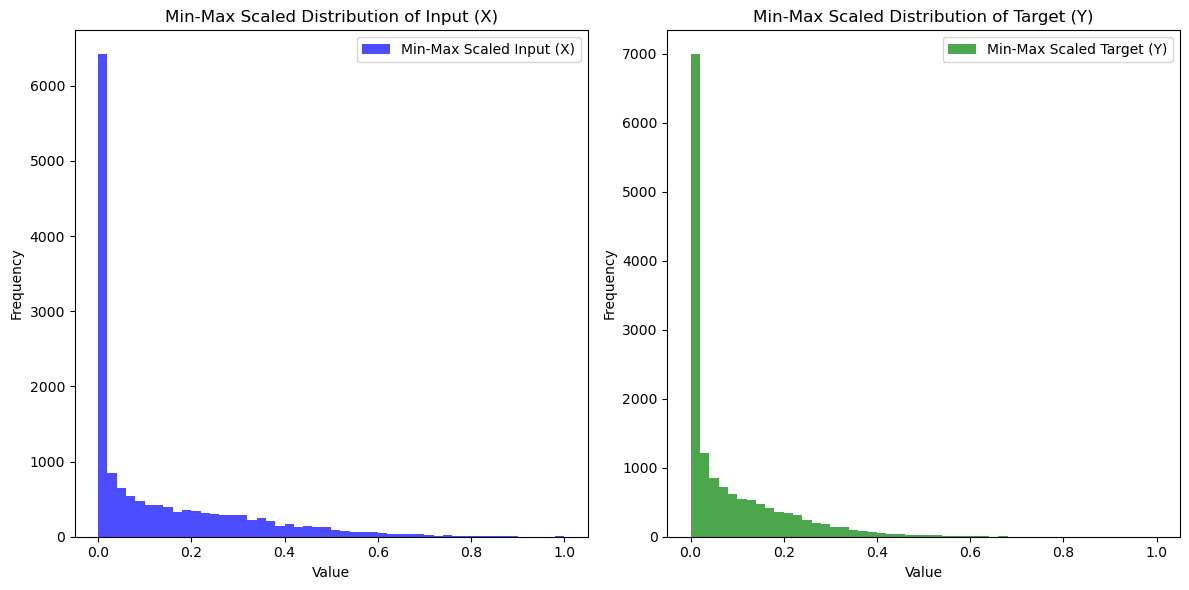

In [12]:
import matplotlib.pyplot as plt

# Flatten the tensors for easier visualization
inference_sd_day7_minmaxed_flat = inference_sd_day7_minmaxed.flatten().cpu().numpy()
inference_sd_day10_minmaxed_flat = inference_sd_day10_minmaxed.flatten().cpu().numpy()

# Plot histograms
plt.figure(figsize=(12, 6))

# Input (X) histogram after Min-Max scaling
plt.subplot(1, 2, 1)
plt.hist(inference_sd_day7_minmaxed_flat, bins=50, color='blue', alpha=0.7, label='Min-Max Scaled Input (X)')
plt.title('Min-Max Scaled Distribution of Input (X)')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()

# Target (Y) histogram after Min-Max scaling
plt.subplot(1, 2, 2)
plt.hist(inference_sd_day10_minmaxed_flat, bins=50, color='green', alpha=0.7, label='Min-Max Scaled Target (Y)')
plt.title('Min-Max Scaled Distribution of Target (Y)')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()


In [13]:
from scipy.stats import boxcox
import torch

# Flatten the data and apply Box-Cox (Box-Cox requires positive values)
inference_sd_day7_flat = inference_sd_day7.flatten().cpu().numpy() + 1e-6  # Add small constant to avoid zero
inference_sd_day10_flat = inference_sd_day10.flatten().cpu().numpy() + 1e-6

inference_sd_day7_boxcox, lambda_7 = boxcox(inference_sd_day7_flat)
inference_sd_day10_boxcox, lambda_10 = boxcox(inference_sd_day10_flat)

print(f"Box-Cox Lambda for Input (X): {lambda_7}")
print(f"Box-Cox Lambda for Target (Y): {lambda_10}")


Box-Cox Lambda for Input (X): 0.12615580108057536
Box-Cox Lambda for Target (Y): 0.1262638047055569


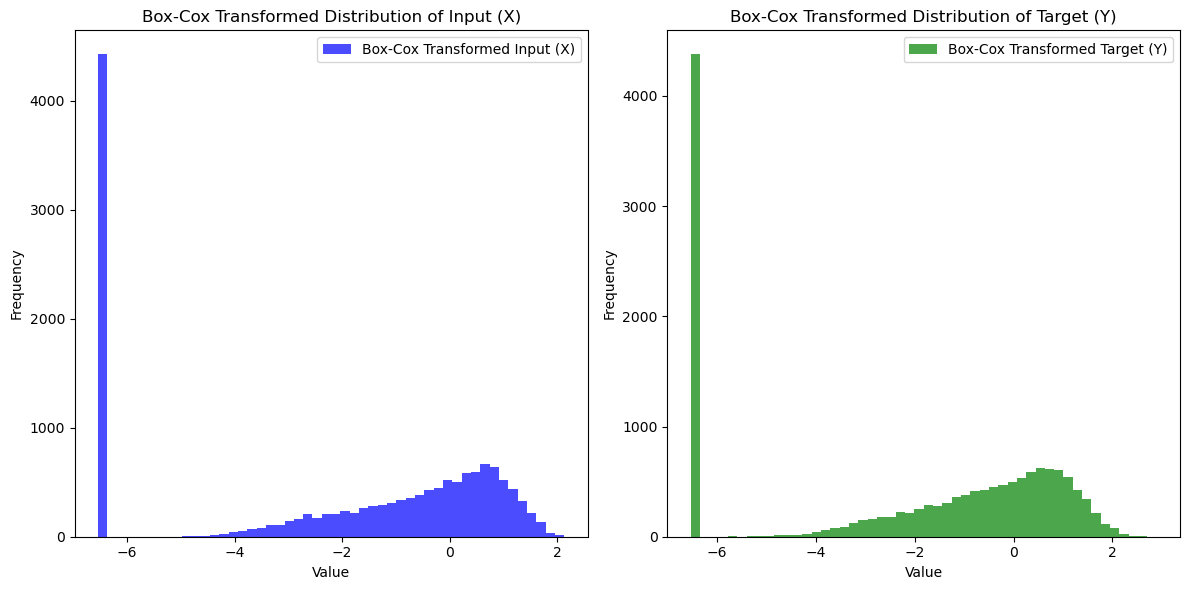

In [14]:
# Plot histograms after Box-Cox transformation
plt.figure(figsize=(12, 6))

# Input (X)
plt.subplot(1, 2, 1)
plt.hist(inference_sd_day7_boxcox, bins=50, color='blue', alpha=0.7, label='Box-Cox Transformed Input (X)')
plt.title('Box-Cox Transformed Distribution of Input (X)')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()

# Target (Y)
plt.subplot(1, 2, 2)
plt.hist(inference_sd_day10_boxcox, bins=50, color='green', alpha=0.7, label='Box-Cox Transformed Target (Y)')
plt.title('Box-Cox Transformed Distribution of Target (Y)')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()


# CONTROL

In [16]:
save_dir = r"C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\Ranking(prediction)_model\resizeonly_feats\after"

train_day7_feats = torch.load(os.path.join(save_dir, 'controlall_day7.pt'))
train_day10_feats = torch.load(os.path.join(save_dir, 'controlall_day10.pt'))

# Load training features
#train_day7_feats = torch.load('train_day7_control.pt')
#train_day10_feats = torch.load('train_day10_control.pt')


C:\Users\k54739\AppData\Local\Temp\ipykernel_15704\1013844656.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_day7_feats = torch.load(os.path.join(save_dir, 'contr

In [17]:
train_day7_feats.shape 


torch.Size([130, 20])

In [18]:
train_day7_feats 


tensor([[-2.4109,  1.7092,  2.1455,  ...,  2.8293, -0.0048,  2.3206],
        [ 1.4746,  0.2071,  0.3191,  ..., -1.7704,  0.5372,  1.2113],
        [-1.8144,  0.3725,  3.1913,  ..., -1.2352, -1.4409, -1.7799],
        ...,
        [-1.2522,  0.1834,  3.4701,  ..., -1.0076, -1.6476, -1.2189],
        [ 0.2417,  1.6646, -0.3658,  ...,  0.0539, -1.3019,  0.4209],
        [-2.3250, -0.1825,  3.9498,  ..., -0.0924, -1.7484,  0.2609]])

In [19]:
train_day10_feats 


tensor([[-1.1964e+00,  2.2052e+00, -5.5316e-01,  ...,  1.6685e+00,
          8.3629e-01, -7.3377e-01],
        [-6.6915e-01,  1.1130e+00, -6.5315e-01,  ...,  1.1131e+00,
          6.0711e-01, -3.0564e-01],
        [ 1.4813e-01,  1.0992e+00, -2.8595e-01,  ..., -1.0824e+00,
         -6.3161e-01, -1.9114e-01],
        ...,
        [ 4.9812e-01,  1.2906e+00, -2.4818e-01,  ..., -2.3282e-01,
         -2.4944e-01, -3.7170e-01],
        [ 1.5638e-03,  3.3037e-01,  9.2135e-01,  ..., -1.2492e+00,
          3.5355e-01, -5.5935e-01],
        [-4.6277e-01,  1.6472e+00,  1.3951e+00,  ...,  4.4830e-01,
         -1.0259e+00, -1.9911e+00]])

In [20]:
# Print lengths of feature tensors
print(f"Number of training Day 7 features: {len(train_day7_feats)}")
print(f"Number of training Day 10 features: {len(train_day10_feats)}")


Number of training Day 7 features: 130
Number of training Day 10 features: 130


In [21]:
# Print shapes of feature tensors
print(f"Shape of training Day 7 features: {train_day7_feats.shape}")
print(f"Shape of training Day 10 features: {train_day10_feats.shape}")


Shape of training Day 7 features: torch.Size([130, 20])
Shape of training Day 10 features: torch.Size([130, 20])


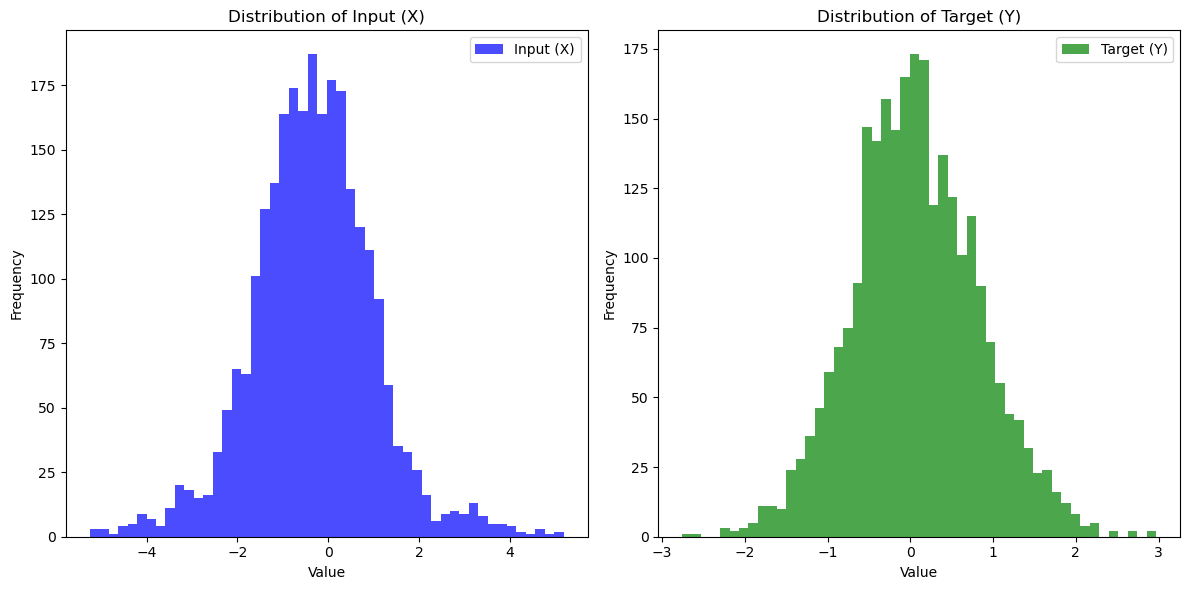

Input (X): Mean=-0.3310, Std=1.3458
Target (Y): Mean=0.0641, Std=0.7643


In [22]:
import matplotlib.pyplot as plt

# Plot histograms for input (X) and target (Y)
plt.figure(figsize=(12, 6))

# Flatten tensors to 1D for easier visualization
train_day7_feats_flat = train_day7_feats.flatten().cpu().numpy()
train_day10_feats_flat = train_day10_feats.flatten().cpu().numpy()

# Input (X) histogram
plt.subplot(1, 2, 1)
plt.hist(train_day7_feats_flat, bins=50, color='blue', alpha=0.7, label='Input (X)')
plt.title('Distribution of Input (X)')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()

# Target (Y) histogram
plt.subplot(1, 2, 2)
plt.hist(train_day10_feats_flat, bins=50, color='green', alpha=0.7, label='Target (Y)')
plt.title('Distribution of Target (Y)')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"Input (X): Mean={train_day7_feats.mean():.4f}, Std={train_day7_feats.std():.4f}")
print(f"Target (Y): Mean={train_day10_feats.mean():.4f}, Std={train_day10_feats.std():.4f}")


from scipy.stats import boxcox
import torch

# Flatten the data and apply Box-Cox (Box-Cox requires positive values)
train_day7_feats_flat = train_day7_feats.flatten().cpu().numpy() + 1e-6  # Add small constant to avoid zero
train_day10_feats_flat = train_day10_feats.flatten().cpu().numpy() + 1e-6

train_day7_feats_boxcox, lambda_7 = boxcox(train_day7_feats_flat)
train_day10_feats_boxcox, lambda_10 = boxcox(train_day10_feats_flat)

print(f"Box-Cox Lambda for Input (X): {lambda_7}")
print(f"Box-Cox Lambda for Target (Y): {lambda_10}")


# Plot histograms after Box-Cox transformation
plt.figure(figsize=(12, 6))

# Input (X)
plt.subplot(1, 2, 1)
plt.hist(train_day7_feats_boxcox, bins=50, color='blue', alpha=0.7, label='Box-Cox Transformed Input (X)')
plt.title('Box-Cox Transformed Distribution of Input (X)')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()

# Target (Y)
plt.subplot(1, 2, 2)
plt.hist(train_day10_feats_boxcox, bins=50, color='green', alpha=0.7, label='Box-Cox Transformed Target (Y)')
plt.title('Box-Cox Transformed Distribution of Target (Y)')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()


# Log Transformation + Min-Max Scaling
def log_transform(data):
    return torch.log(data + 1)  # Add 1 to avoid log(0)

# Apply Log Transformation
train_day7_feats_log = log_transform(train_day7_feats)
train_day10_feats_log = log_transform(train_day10_feats)

import matplotlib.pyplot as plt

# Flatten the tensors for easier visualization
train_day7_feats_log_flat = train_day7_feats_log.flatten().cpu().numpy()
train_day10_feats_log_flat = train_day10_feats_log.flatten().cpu().numpy()

# Plot histograms
plt.figure(figsize=(12, 6))

# Input (X) histogram after log transformation
plt.subplot(1, 2, 1)
plt.hist(train_day7_feats_log_flat, bins=50, color='blue', alpha=0.7, label='Log-Transformed Input (X)')
plt.title('Log-Transformed Distribution of Input (X)')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()

# Target (Y) histogram after log transformation
plt.subplot(1, 2, 2)
plt.hist(train_day10_feats_log_flat, bins=50, color='green', alpha=0.7, label='Log-Transformed Target (Y)')
plt.title('Log-Transformed Distribution of Target (Y)')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()


In [23]:
def z_score_normalization(tensor):
    """
    Perform Z-score normalization on a PyTorch tensor.
    
    Args:
        tensor (torch.Tensor): Input tensor to be normalized.
    
    Returns:
        torch.Tensor: Z-score normalized tensor.
        torch.Tensor: Mean of the input tensor.
        torch.Tensor: Standard deviation of the input tensor.
    """
    mean = tensor.mean()
    std = tensor.std()
    z_score_normalized = (tensor - mean) / std
    return z_score_normalized, mean, std


In [24]:
# Z-Score Normalization for train_day7_feats
train_day7_feats_scaled, train_day7_feats_mean, train_day7_feats_std = z_score_normalization(train_day7_feats)
print("Train Day 7 Mean:", train_day7_feats_mean)
print("Train Day 7 Std Dev:", train_day7_feats_std)

# Z-Score Normalization for train_day10_feats
train_day10_feats_scaled, train_day10_feats_mean, train_day10_feats_std = z_score_normalization(train_day10_feats)
print("Train Day 10 Mean:", train_day10_feats_mean)
print("Train Day 10 Std Dev:", train_day10_feats_std)


Train Day 7 Mean: tensor(-0.3310)
Train Day 7 Std Dev: tensor(1.3458)
Train Day 10 Mean: tensor(0.0641)
Train Day 10 Std Dev: tensor(0.7643)


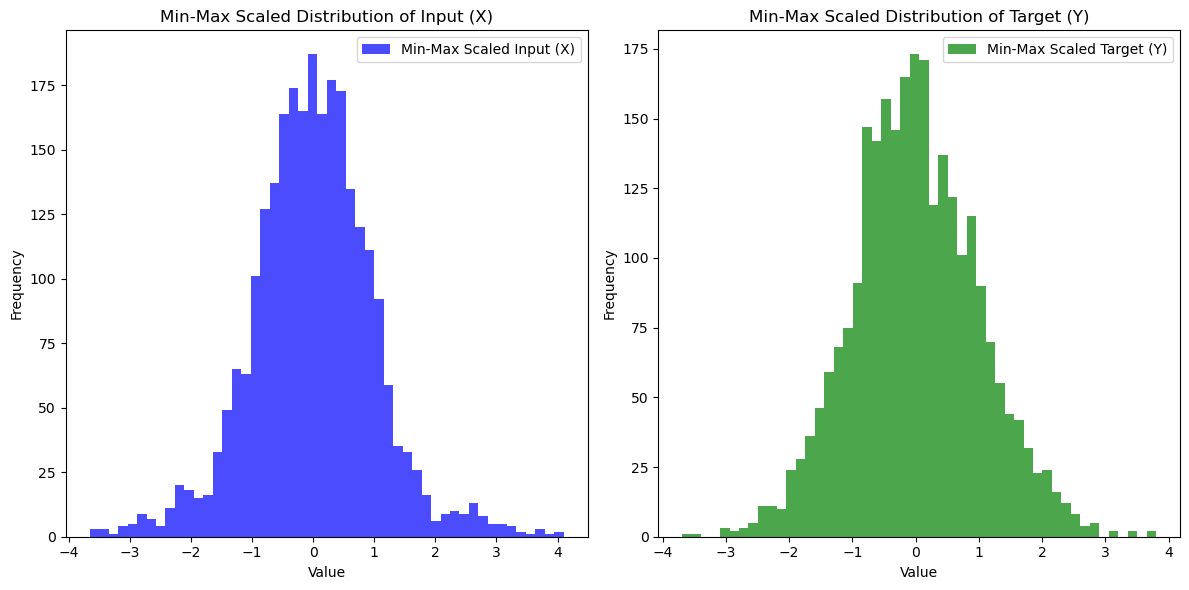

In [25]:
import matplotlib.pyplot as plt

# Flatten the tensors for easier visualization
train_day7_feats_minmaxed_flat = train_day7_feats_scaled.flatten().cpu().numpy()
train_day10_feats_minmaxed_flat = train_day10_feats_scaled.flatten().cpu().numpy()

# Plot histograms
plt.figure(figsize=(12, 6))

# Input (X) histogram after Min-Max scaling
plt.subplot(1, 2, 1)
plt.hist(train_day7_feats_minmaxed_flat, bins=50, color='blue', alpha=0.7, label='Min-Max Scaled Input (X)')
plt.title('Min-Max Scaled Distribution of Input (X)')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()

# Target (Y) histogram after Min-Max scaling
plt.subplot(1, 2, 2)
plt.hist(train_day10_feats_minmaxed_flat, bins=50, color='green', alpha=0.7, label='Min-Max Scaled Target (Y)')
plt.title('Min-Max Scaled Distribution of Target (Y)')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()


import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

class FeaturePredictor(nn.Module):
    def __init__(self, input_size=512, output_size=512):
        super(FeaturePredictor, self).__init__()
        self.model = nn.Sequential(
            # 512 → 256
            nn.Linear(input_size, 256),
            nn.BatchNorm1d(256),  # Batch Normalization
            nn.ReLU(),
            nn.Dropout(0.3),  # Dropout with 30% probability

            # 256 → 128
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),

            # 128 → 64
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),

            # 64 → 32
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.3),

            # 32 → 16
            nn.Linear(32, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Dropout(0.3),

            # 16 → 8
            nn.Linear(16, 8),
            nn.BatchNorm1d(8),
            nn.ReLU(),
            nn.Dropout(0.3),

            # 8 → 16
            nn.Linear(8, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Dropout(0.3),

            # 16 → 32
            nn.Linear(16, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.3),

            # 32 → 64
            nn.Linear(32, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),

            # 64 → 128
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),

            # 128 → 256
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),

            # 256 → 512
            nn.Linear(256, output_size),
            nn.BatchNorm1d(output_size),  # BatchNorm for the output
            nn.ReLU()
        )
    
    def forward(self, x):
        return self.model(x)


import torch.nn as nn

class FeaturePredictor(nn.Module):
    def __init__(self, input_size=512, output_size=512):
        super(FeaturePredictor, self).__init__()
        self.model = nn.Sequential(
            # 512 → 256
            nn.Linear(input_size, 256),
            nn.BatchNorm1d(256),  # Batch Normalization
            nn.ReLU(),
            nn.Dropout(0.3),  # Dropout with 30% probability

            # 256 → 64
            nn.Linear(256, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),

            # 64 → 8
            nn.Linear(64, 8),
            nn.BatchNorm1d(8),
            nn.ReLU(),
            nn.Dropout(0.3),

            # 8 → 64
            nn.Linear(8, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),

            # 64 → 256
            nn.Linear(64, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),

            # 256 → 512
            nn.Linear(256, output_size),
            nn.BatchNorm1d(output_size),  # Add BatchNorm for the output as well
            nn.ReLU()
        )
    
    def forward(self, x):
        return self.model(x)


In [33]:
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

class FeaturePredictor(nn.Module):
    def __init__(self, input_size=20, output_size=20):
        super(FeaturePredictor, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 4),
            nn.ReLU(),
            nn.Linear(4, 8),
            nn.ReLU(),
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.Linear(16,output_size)
        )
    
    def forward(self, x):
        return self.model(x)

In [34]:
model = FeaturePredictor()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [35]:
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, Subset

In [36]:
from torch.utils.data import TensorDataset

optimizer_class = torch.optim.Adam



In [37]:
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, Subset
import numpy as np
import torch


In [38]:

class EarlyStopping:
    def __init__(self, patience=10, delta=0.0):
        """
        Args:
            patience (int): How many epochs to wait after the last validation loss improvement.
            delta (float): Minimum change in the validation loss to qualify as an improvement.
        """
        self.patience = patience
        self.delta = delta
        self.best_loss = None
        self.no_improvement_epochs = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None or val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.no_improvement_epochs = 0
        else:
            self.no_improvement_epochs += 1
            if self.no_improvement_epochs >= self.patience:
                self.early_stop = True


def cross_validate_with_early_stopping(
    model_class, dataset, criterion, optimizer_class, num_epochs=50, n_splits=5, patience=10, device='cuda'
):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    histories = []
    best_models = []

    for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset)):
        print(f"Fold {fold + 1}/{n_splits}")

        # Create subsets for this fold
        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)

        # Create DataLoaders
        train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)

        # Initialize the model, optimizer, and early stopping for this fold
        model = model_class().to(device)
        optimizer = optimizer_class(model.parameters(), lr=1e-4)
        early_stopping = EarlyStopping(patience=patience)

        # Training and validation loop
        history = {'train_loss': [], 'val_loss': []}
        for epoch in range(num_epochs):
            # Training phase
            model.train()
            train_loss = 0.0
            for batch_inputs, batch_targets in train_loader:
                batch_inputs, batch_targets = batch_inputs.to(device), batch_targets.to(device)

                # Forward pass
                outputs = model(batch_inputs)
                loss = criterion(outputs, batch_targets)
                train_loss += loss.item()

                # Backward pass and optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            train_loss /= len(train_loader)
            history['train_loss'].append(train_loss)

            # Validation phase
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for batch_inputs, batch_targets in val_loader:
                    batch_inputs, batch_targets = batch_inputs.to(device), batch_targets.to(device)
                    outputs = model(batch_inputs)
                    loss = criterion(outputs, batch_targets)
                    val_loss += loss.item()

            val_loss /= len(val_loader)
            history['val_loss'].append(val_loss)

            print(f"Epoch [{epoch + 1}/{num_epochs}] Fold {fold + 1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

            # Check early stopping
            early_stopping(val_loss)
            if early_stopping.early_stop:
                print(f"Early stopping at epoch {epoch + 1} for fold {fold + 1}")
                break

        # Save the best model for this fold
        best_models.append(model.state_dict())
        histories.append(history)

    return histories, best_models



In [39]:
# MIN MAX
dataset = TensorDataset(train_day7_feats_scaled, train_day10_feats_scaled)

cv_histories, best_models = cross_validate_with_early_stopping(
    model_class=FeaturePredictor,
    dataset=dataset,
    criterion=nn.MSELoss(),
    optimizer_class=torch.optim.Adam,
    num_epochs=1500,
    patience=500
)


Fold 1/5
Epoch [1/1500] Fold 1, Train Loss: 1.0175, Val Loss: 0.8196
Epoch [2/1500] Fold 1, Train Loss: 1.0342, Val Loss: 0.8184
Epoch [3/1500] Fold 1, Train Loss: 1.1032, Val Loss: 0.8173
Epoch [4/1500] Fold 1, Train Loss: 1.0854, Val Loss: 0.8162
Epoch [5/1500] Fold 1, Train Loss: 1.0304, Val Loss: 0.8151
Epoch [6/1500] Fold 1, Train Loss: 1.1061, Val Loss: 0.8140
Epoch [7/1500] Fold 1, Train Loss: 1.0150, Val Loss: 0.8129
Epoch [8/1500] Fold 1, Train Loss: 1.1647, Val Loss: 0.8118
Epoch [9/1500] Fold 1, Train Loss: 1.0595, Val Loss: 0.8108
Epoch [10/1500] Fold 1, Train Loss: 1.0337, Val Loss: 0.8097
Epoch [11/1500] Fold 1, Train Loss: 1.0493, Val Loss: 0.8087
Epoch [12/1500] Fold 1, Train Loss: 1.0918, Val Loss: 0.8076
Epoch [13/1500] Fold 1, Train Loss: 1.0229, Val Loss: 0.8066
Epoch [14/1500] Fold 1, Train Loss: 1.0380, Val Loss: 0.8056
Epoch [15/1500] Fold 1, Train Loss: 1.0237, Val Loss: 0.8046
Epoch [16/1500] Fold 1, Train Loss: 1.0106, Val Loss: 0.8035
Epoch [17/1500] Fold 1, 

In [40]:
# Example: Average validation loss across folds
avg_val_loss = np.mean([history['val_loss'][-1] for history in cv_histories])
print(f"Average Validation Loss: {avg_val_loss:.4f}")


Average Validation Loss: 0.6036


In [41]:
# Analyze the best results for each fold outside the training function
for fold_idx, history in enumerate(cv_histories):
    # Find the epoch with the lowest validation loss
    best_epoch = int(np.argmin(history['val_loss'])) + 1  # Adding 1 because epochs are 1-indexed
    best_val_loss = history['val_loss'][best_epoch - 1]  # Accessing the loss using 0-based index
    best_train_loss = history['train_loss'][best_epoch - 1]

    print(f"Fold {fold_idx + 1}:")
    print(f"  Best Validation Loss = {best_val_loss:.4f}")
    print(f"  Corresponding Training Loss = {best_train_loss:.4f}")
    print(f"  Best Epoch = {best_epoch}")


Fold 1:
  Best Validation Loss = 0.4958
  Corresponding Training Loss = 0.4693
  Best Epoch = 1477
Fold 2:
  Best Validation Loss = 0.6013
  Corresponding Training Loss = 0.4939
  Best Epoch = 1498
Fold 3:
  Best Validation Loss = 0.8038
  Corresponding Training Loss = 0.5027
  Best Epoch = 1311
Fold 4:
  Best Validation Loss = 0.5943
  Corresponding Training Loss = 0.5407
  Best Epoch = 1497
Fold 5:
  Best Validation Loss = 0.4998
  Corresponding Training Loss = 0.6137
  Best Epoch = 879


# MIN MAX
dataset = TensorDataset(train_day7_feats_minmaxed, train_day10_feats_minmaxed)

cv_histories, best_models = cross_validate_with_early_stopping(
    model_class=FeaturePredictor,
    dataset=dataset,
    criterion=nn.MSELoss(),
    optimizer_class=torch.optim.Adam,
    num_epochs=1500,
    patience=500
)


In [18]:
# Example: Average validation loss across folds
avg_val_loss = np.mean([history['val_loss'][-1] for history in cv_histories])
print(f"Average Validation Loss: {avg_val_loss:.4f}")


Average Validation Loss: 0.0155


In [19]:
# Analyze the best results for each fold outside the training function
for fold_idx, history in enumerate(cv_histories):
    # Find the epoch with the lowest validation loss
    best_epoch = int(np.argmin(history['val_loss'])) + 1  # Adding 1 because epochs are 1-indexed
    best_val_loss = history['val_loss'][best_epoch - 1]  # Accessing the loss using 0-based index
    best_train_loss = history['train_loss'][best_epoch - 1]

    print(f"Fold {fold_idx + 1}:")
    print(f"  Best Validation Loss = {best_val_loss:.4f}")
    print(f"  Corresponding Training Loss = {best_train_loss:.4f}")
    print(f"  Best Epoch = {best_epoch}")


Fold 1:
  Best Validation Loss = 0.0134
  Corresponding Training Loss = 0.0216
  Best Epoch = 1460
Fold 2:
  Best Validation Loss = 0.0142
  Corresponding Training Loss = 0.0149
  Best Epoch = 1495
Fold 3:
  Best Validation Loss = 0.0158
  Corresponding Training Loss = 0.0177
  Best Epoch = 936
Fold 4:
  Best Validation Loss = 0.0159
  Corresponding Training Loss = 0.0191
  Best Epoch = 784
Fold 5:
  Best Validation Loss = 0.0143
  Corresponding Training Loss = 0.0210
  Best Epoch = 709


# MIN MAX
dataset = TensorDataset(train_day7_feats_minmaxed, train_day10_feats_minmaxed)

cv_histories, best_models = cross_validate_with_early_stopping(
    model_class=FeaturePredictor,
    dataset=dataset,
    criterion=nn.MSELoss(),
    optimizer_class=torch.optim.Adam,
    num_epochs=1500,
    patience=500
)


# without normalisation
dataset = TensorDataset(train_day7_feats, train_day10_feats)

cv_histories, best_models = cross_validate_with_early_stopping(
    model_class=FeaturePredictor,
    dataset=dataset,
    criterion=nn.MSELoss(),
    optimizer_class=torch.optim.Adam,
    num_epochs=1500,
    patience=500
)


# MIN MAX

In [42]:
import os

# Define the directory where models will be saved
save_dir = r'C:\Users\k54739\saved_model\ranking\simclr\minmax_scaled\resizeonly\after'
os.makedirs(save_dir, exist_ok=True)  # Create the directory if it doesn't exist

# Save each fold's best model to the directory
for i, model_state in enumerate(best_models):
    save_path = os.path.join(save_dir, f'best_model_fold_{i+1}.pth')
    torch.save(model_state, save_path)

print(f"Models saved to {save_dir}")


Models saved to C:\Users\k54739\saved_model\ranking\simclr\minmax_scaled\resizeonly\after


In [19]:
# Example: Average validation loss across folds
avg_val_loss = np.mean([history['val_loss'][-1] for history in cv_histories])
print(f"Average Validation Loss: {avg_val_loss:.4f}")


Average Validation Loss: 0.0129


In [ ]:
#loss started from 0.03

In [20]:
# Analyze the best results for each fold outside the training function
for fold_idx, history in enumerate(cv_histories):
    # Find the epoch with the lowest validation loss
    best_epoch = int(np.argmin(history['val_loss'])) + 1  # Adding 1 because epochs are 1-indexed
    best_val_loss = history['val_loss'][best_epoch - 1]  # Accessing the loss using 0-based index
    best_train_loss = history['train_loss'][best_epoch - 1]

    print(f"Fold {fold_idx + 1}:")
    print(f"  Best Validation Loss = {best_val_loss:.4f}")
    print(f"  Corresponding Training Loss = {best_train_loss:.4f}")
    print(f"  Best Epoch = {best_epoch}")


Fold 1:
  Best Validation Loss = 0.0104
  Corresponding Training Loss = 0.0088
  Best Epoch = 169
Fold 2:
  Best Validation Loss = 0.0120
  Corresponding Training Loss = 0.0082
  Best Epoch = 227
Fold 3:
  Best Validation Loss = 0.0116
  Corresponding Training Loss = 0.0084
  Best Epoch = 271
Fold 4:
  Best Validation Loss = 0.0099
  Corresponding Training Loss = 0.0088
  Best Epoch = 185
Fold 5:
  Best Validation Loss = 0.0093
  Corresponding Training Loss = 0.0087
  Best Epoch = 302


In [43]:
def plot_loss_curves_separately(cv_histories):
    """
    Plot training and validation loss curves for each fold in separate figures.
    
    Args:
        cv_histories (list): List of loss histories for each fold.
    """
    # Plot Training Loss
    plt.figure(figsize=(10, 6))
    for fold, history in enumerate(cv_histories):
        epochs = range(1, len(history['train_loss']) + 1)  # Dynamically set range
        plt.plot(epochs, history['train_loss'], label=f'Fold {fold + 1} Train Loss')
    plt.title('Training Loss per Fold')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot Validation Loss
    plt.figure(figsize=(10, 6))
    for fold, history in enumerate(cv_histories):
        epochs = range(1, len(history['val_loss']) + 1)  # Dynamically set range
        plt.plot(epochs, history['val_loss'], label=f'Fold {fold + 1} Val Loss', linestyle='--')
    plt.title('Validation Loss per Fold')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


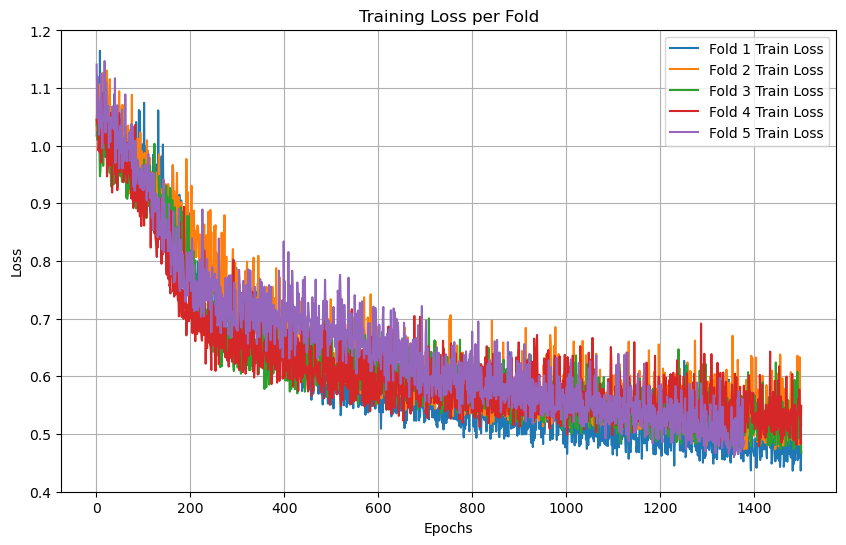

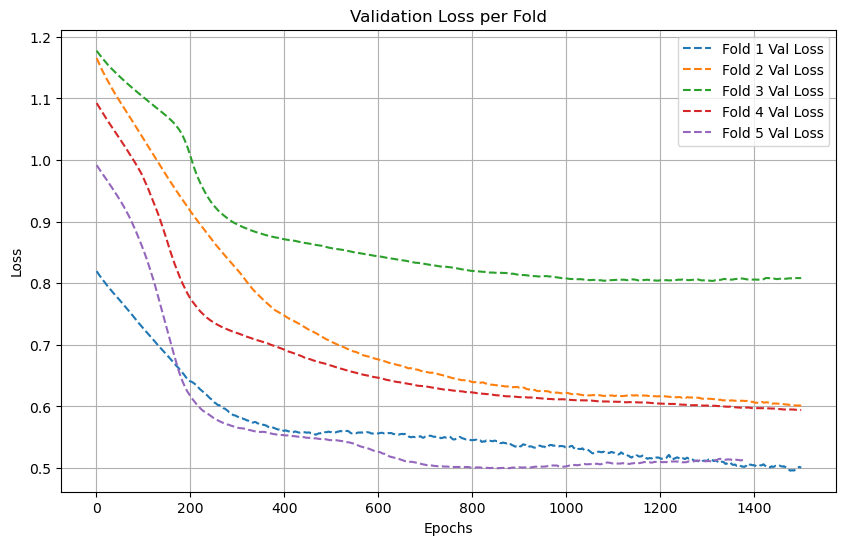

In [44]:
import matplotlib.pyplot as plt
plot_loss_curves_separately(cv_histories)


# without normalisation second try

In [25]:
# Analyze the best results for each fold outside the training function
for fold_idx, history in enumerate(cv_histories):
    # Find the epoch with the lowest validation loss
    best_epoch = int(np.argmin(history['val_loss'])) + 1  # Adding 1 because epochs are 1-indexed
    best_val_loss = history['val_loss'][best_epoch - 1]  # Accessing the loss using 0-based index
    best_train_loss = history['train_loss'][best_epoch - 1]

    print(f"Fold {fold_idx + 1}:")
    print(f"  Best Validation Loss = {best_val_loss:.4f}")
    print(f"  Corresponding Training Loss = {best_train_loss:.4f}")
    print(f"  Best Epoch = {best_epoch}")


Fold 1:
  Best Validation Loss = 0.8875
  Corresponding Training Loss = 0.7412
  Best Epoch = 499
Fold 2:
  Best Validation Loss = 1.0025
  Corresponding Training Loss = 0.7160
  Best Epoch = 431
Fold 3:
  Best Validation Loss = 0.9107
  Corresponding Training Loss = 0.7098
  Best Epoch = 367
Fold 4:
  Best Validation Loss = 0.7906
  Corresponding Training Loss = 0.6153
  Best Epoch = 939
Fold 5:
  Best Validation Loss = 0.8438
  Corresponding Training Loss = 0.7240
  Best Epoch = 453


In [20]:
import os

# Define the directory where models will be saved
save_dir = r'C:\Users\k54739\saved_model\ranking\simclr\minmax_scaled'
os.makedirs(save_dir, exist_ok=True)  # Create the directory if it doesn't exist

# Save each fold's best model to the directory
for i, model_state in enumerate(best_models):
    save_path = os.path.join(save_dir, f'best_model_fold_{i+1}.pth')
    torch.save(model_state, save_path)

print(f"Models saved to {save_dir}")


Models saved to C:\Users\k54739\saved_model\ranking\simclr\minmax_scaled


In [26]:
# Example: Average validation loss across folds
avg_val_loss = np.mean([history['val_loss'][-1] for history in cv_histories])
print(f"Average Validation Loss: {avg_val_loss:.4f}")


Average Validation Loss: 1.0335


In [22]:
def plot_loss_curves_separately(cv_histories):
    """
    Plot training and validation loss curves for each fold in separate figures.
    
    Args:
        cv_histories (list): List of loss histories for each fold.
    """
    # Plot Training Loss
    plt.figure(figsize=(10, 6))
    for fold, history in enumerate(cv_histories):
        epochs = range(1, len(history['train_loss']) + 1)  # Dynamically set range
        plt.plot(epochs, history['train_loss'], label=f'Fold {fold + 1} Train Loss')
    plt.title('Training Loss per Fold')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot Validation Loss
    plt.figure(figsize=(10, 6))
    for fold, history in enumerate(cv_histories):
        epochs = range(1, len(history['val_loss']) + 1)  # Dynamically set range
        plt.plot(epochs, history['val_loss'], label=f'Fold {fold + 1} Val Loss', linestyle='--')
    plt.title('Validation Loss per Fold')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


In [23]:
import matplotlib.pyplot as plt

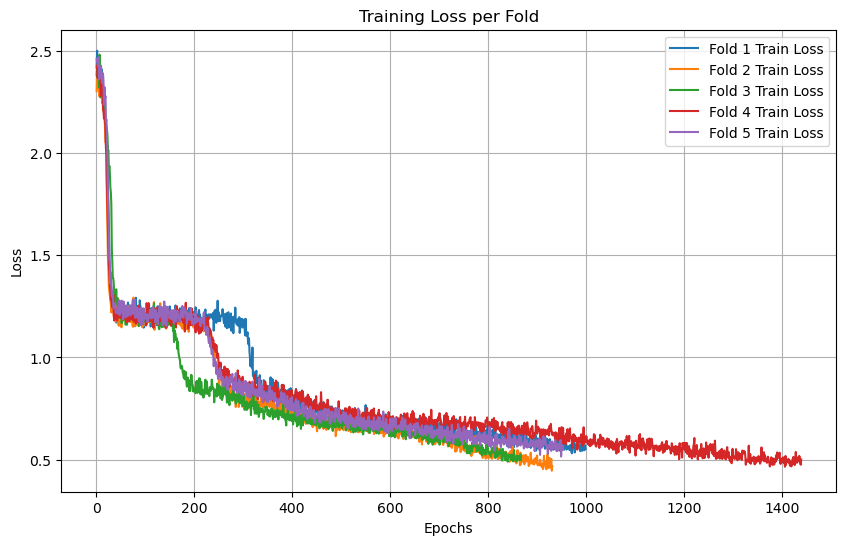

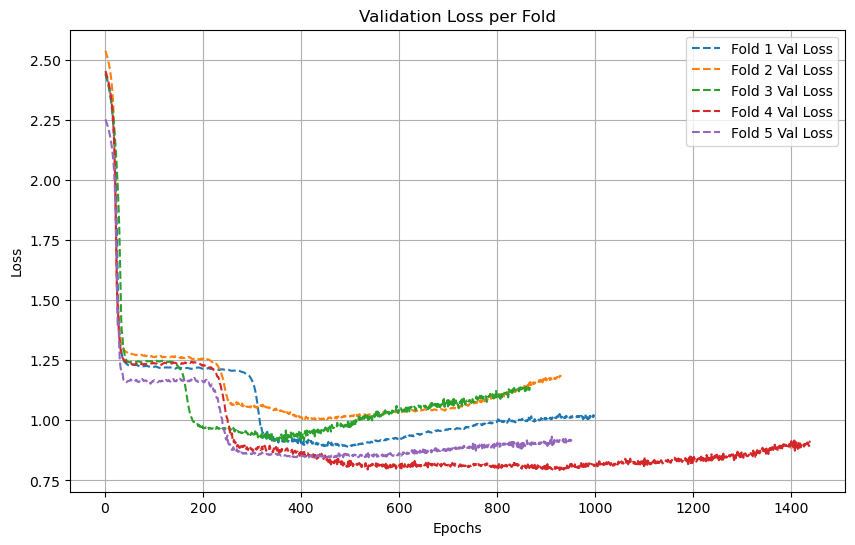

In [24]:
plot_loss_curves_separately(cv_histories)
import matplotlib.pyplot as plt


# without normalisation first try

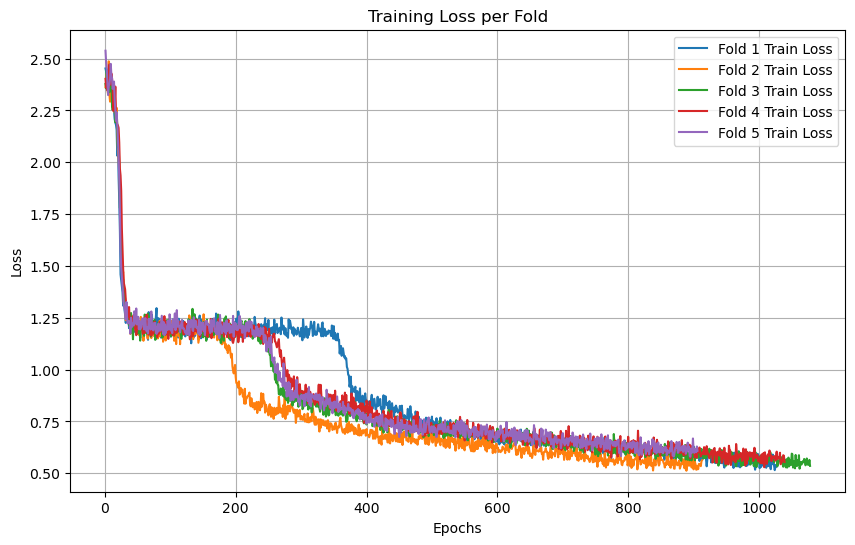

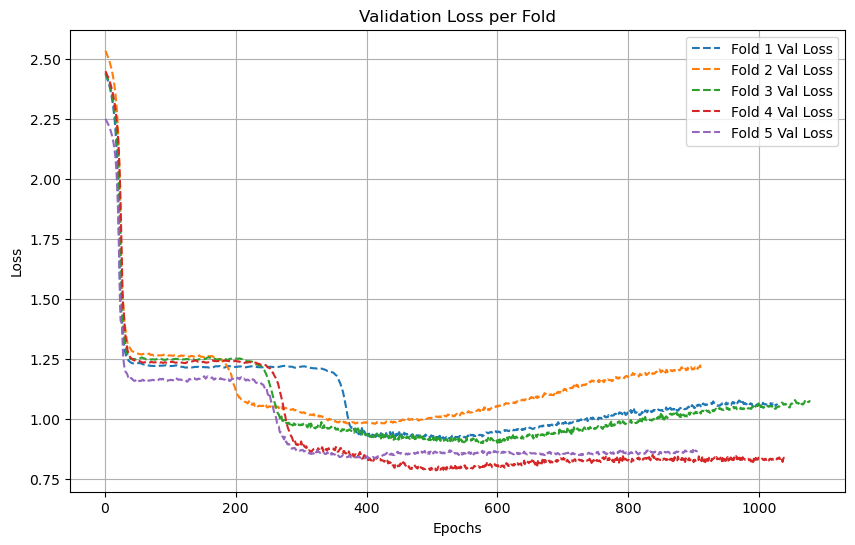

In [17]:
plot_loss_curves_separately(cv_histories)


# Inference 

In [1]:
import os
import torch
from torch import nn, optim
import numpy

from torch.utils.data import TensorDataset, DataLoader

In [2]:
# Load training features
train_day7_feats = torch.load('train_day7_control.pt')
train_day10_feats = torch.load('train_day10_control.pt')


C:\Users\k54739\AppData\Local\Temp\ipykernel_22920\2729202165.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_day7_feats = torch.load('train_day7_control.pt')
C:\U

In [3]:
print(type(train_day7_feats))
print(type(train_day10_feats))

<class 'torch.Tensor'>
<class 'torch.Tensor'>


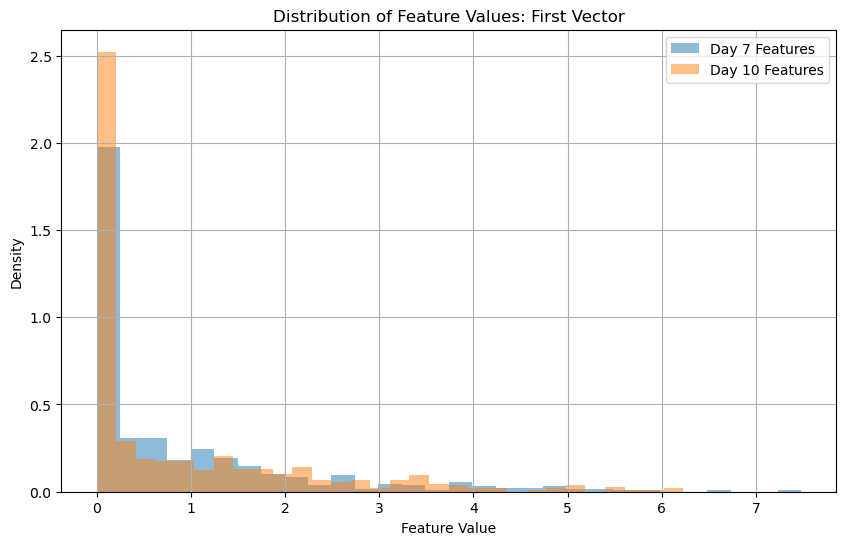

In [4]:
import matplotlib.pyplot as plt
import torch


# Extract the first feature vector from both
values_day7 = train_day7_feats[0].numpy()  # Convert to NumPy array
values_day10 = train_day10_feats[0].numpy()  # Convert to NumPy array

# Plot histograms to compare distributions
plt.figure(figsize=(10, 6))

plt.hist(values_day7, bins=30, alpha=0.5, label='Day 7 Features', density=True)
plt.hist(values_day10, bins=30, alpha=0.5, label='Day 10 Features', density=True)

plt.title('Distribution of Feature Values: First Vector')
plt.xlabel('Feature Value')
plt.ylabel('Density')
plt.legend()
plt.grid(True)

plt.show()


In [5]:
# Print lengths of feature tensors
print(f"Number of training Day 7 features: {len(train_day7_feats)}")
print(f"Number of training Day 10 features: {len(train_day10_feats)}")
# Print shapes of feature tensors
print(f"Shape of training Day 7 features: {train_day7_feats.shape}")
print(f"Shape of training Day 10 features: {train_day10_feats.shape}")


Number of training Day 7 features: 130
Number of training Day 10 features: 130
Shape of training Day 7 features: torch.Size([130, 512])
Shape of training Day 10 features: torch.Size([130, 512])


In [1]:
import os
import torch
from torch import nn, optim
import numpy

from torch.utils.data import TensorDataset, DataLoader

In [2]:
# Load training features
inference_sd_day7 = torch.load('inference_sd_day7.pt')
inference_sd_day10 = torch.load('inference_sd_day10.pt')


C:\Users\k54739\AppData\Local\Temp\ipykernel_20432\414216957.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  inference_sd_day7 = torch.load('inference_sd_day7.pt')
C:\Us

In [3]:
print(type(inference_sd_day7))
print(type(inference_sd_day10))

<class 'torch.Tensor'>
<class 'torch.Tensor'>


In [4]:
inference_sd_day7

tensor([[0.0000, 0.0000, 1.1177,  ..., 4.7554, 0.0000, 1.2192],
        [1.5634, 0.0768, 0.0073,  ..., 2.1748, 0.9543, 2.6965],
        [0.3505, 0.1033, 0.0952,  ..., 2.0586, 0.0000, 0.9589],
        ...,
        [1.0277, 0.0124, 0.1167,  ..., 3.5348, 0.0294, 2.4753],
        [0.0000, 0.0000, 0.8155,  ..., 2.2120, 0.0000, 0.0000],
        [1.7956, 0.0471, 0.0369,  ..., 2.6556, 0.4420, 3.8215]])

In [5]:
inference_sd_day10

tensor([[2.3463e+00, 0.0000e+00, 0.0000e+00,  ..., 4.3236e-01, 0.0000e+00,
         7.5951e-01],
        [1.8805e+00, 8.1934e-01, 4.6434e-02,  ..., 1.2804e-01, 0.0000e+00,
         3.9649e-01],
        [0.0000e+00, 1.9232e-01, 7.9683e-01,  ..., 6.2674e-02, 0.0000e+00,
         0.0000e+00],
        ...,
        [3.2696e+00, 1.6963e+00, 0.0000e+00,  ..., 1.3728e+00, 3.9278e-03,
         1.7484e+00],
        [4.5861e+00, 0.0000e+00, 0.0000e+00,  ..., 1.0434e+00, 0.0000e+00,
         2.1944e+00],
        [0.0000e+00, 7.1825e-01, 3.9650e-01,  ..., 1.1747e-01, 0.0000e+00,
         0.0000e+00]])

In [6]:
#inference_sd_day7[0].shape
#inference_sd_day10[0].shape

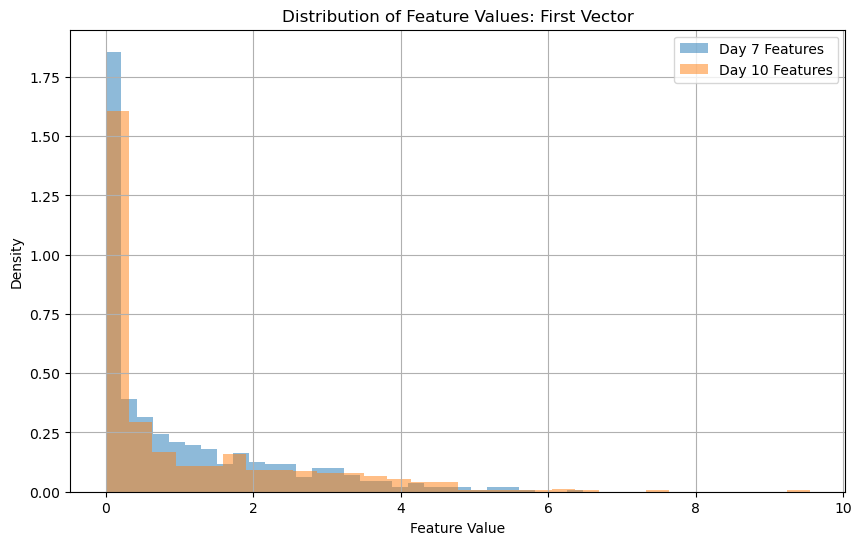

In [7]:
import matplotlib.pyplot as plt
import torch


# Extract the first feature vector from both
values_day7 = inference_sd_day7[0].numpy()  # Convert to NumPy array
values_day10 = inference_sd_day10[0].numpy()  # Convert to NumPy array

# Plot histograms to compare distributions
plt.figure(figsize=(10, 6))

plt.hist(values_day7, bins=30, alpha=0.5, label='Day 7 Features', density=True)
plt.hist(values_day10, bins=30, alpha=0.5, label='Day 10 Features', density=True)

plt.title('Distribution of Feature Values: First Vector')
plt.xlabel('Feature Value')
plt.ylabel('Density')
plt.legend()
plt.grid(True)

plt.show()


In [8]:
# Print lengths of feature tensors
print(f"Number of training Day 7 features: {len(inference_sd_day7)}")
print(f"Number of training Day 10 features: {len(inference_sd_day10)}")
# Print shapes of feature tensors
print(f"Shape of training Day 7 features: {inference_sd_day7.shape}")
print(f"Shape of training Day 10 features: {inference_sd_day10.shape}")


Number of training Day 7 features: 29
Number of training Day 10 features: 29
Shape of training Day 7 features: torch.Size([29, 512])
Shape of training Day 10 features: torch.Size([29, 512])


In [6]:
# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
class FeaturePredictor(nn.Module):
    def __init__(self, input_size=512, output_size=512):
        super(FeaturePredictor, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16,8),
            nn.ReLU(),
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.Linear(16,32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128,256),
            nn.ReLU(),
            nn.Linear(256, output_size)
        )
    
    def forward(self, x):
        return self.model(x)

In [8]:
# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Define the directory where models are saved
load_dir = r'C:\Users\k54739\saved_model\ranking\simclr\minmax_scaled'

# Load a specific fold's best model
model = FeaturePredictor()
load_path = os.path.join(load_dir, 'best_model_fold_5.pth')
model.load_state_dict(torch.load(load_path))
model.to(device)
model.eval()

print(f"Loaded model from {load_path}")


Loaded model from C:\Users\k54739\saved_model\ranking\simclr\minmax_scaled\best_model_fold_5.pth


C:\Users\k54739\AppData\Local\Temp\ipykernel_22920\313922780.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(load_path))


# train

In [9]:
# Min-Max Scaling for Input (X) and Target (Y)
def min_max_scaling(data):
    data_min = data.min()
    data_max = data.max()
    return (data - data_min) / (data_max - data_min), data_min, data_max  # Return scaled data and min/max for inverse scaling

# Apply Min-Max Scaling
train_day7_feats_minmaxed, day7_min, day7_max = min_max_scaling(train_day7_feats)
train_day10_feats_minmaxed, day10_min, day10_max = min_max_scaling(train_day10_feats)
print(day7_min)
print(day7_max)
print(day10_min)
print(day10_max)
# Print summary to confirm
print("After Min-Max Scaling:")
print(f"Input (X): Min={train_day7_feats_minmaxed.min():.4f}, Max={train_day7_feats_minmaxed.max():.4f}")
print(f"Target (Y): Min={train_day10_feats_minmaxed.min():.4f}, Max={train_day10_feats_minmaxed.max():.4f}")



tensor(0.)
tensor(9.1844)
tensor(0.)
tensor(9.1225)
After Min-Max Scaling:
Input (X): Min=0.0000, Max=1.0000
Target (Y): Min=0.0000, Max=1.0000


In [10]:
# Perform inference
with torch.no_grad():
    # Ensure the input features are on the same device as the model
    train_day7_feats_minmaxed = train_day7_feats_minmaxed[2].to(device)
    train_day10_feats_minmaxed = train_day10_feats_minmaxed[2].to(device)
    
    # Predict the target (Day 10) from the input (Day 7)
    predicted_day10 = model(train_day7_feats_minmaxed)

# Evaluate predictions (optional)
# If you have a target (e.g., inference_feat_day10_minmaxed), calculate MSE or another metric
mse_loss = nn.MSELoss()(predicted_day10, train_day10_feats_minmaxed)
print(f"Mean Squared Error on training Data: {mse_loss.item():.4f}")

# Print or save the predictions
#print("Predicted Target (Day 10 features):")
#print(predicted_day10.cpu().numpy())

Mean Squared Error on training Data: 0.0131


In [11]:
import numpy as np

# Predicted and true values (ensure they are detached from PyTorch computation graph)
predicted_day10_np = predicted_day10.cpu().numpy()
train_day10_feats_minmaxed_np = train_day10_feats_minmaxed.cpu().numpy()

# Manually compute the MSE
def compute_mse_manual(predicted, true):
    differences = predicted - true  # Element-wise difference
    squared_differences = differences ** 2  # Element-wise squared difference
    mse = squared_differences.mean()  # Mean of squared differences
    return mse

# Calculate MSE
manual_mse = compute_mse_manual(predicted_day10_np, train_day10_feats_minmaxed_np)

print(f"Manual MSE: {manual_mse:.4f}")


Manual MSE: 0.0131


In [12]:
print(train_day7_feats_minmaxed.shape)
print(train_day10_feats_minmaxed.shape)
print(predicted_day10.shape)


torch.Size([512])
torch.Size([512])
torch.Size([512])


In [10]:
import torch
import matplotlib.pyplot as plt
import torch.nn as nn

# Assume train_day7_feats_minmaxed and train_day10_feats_minmaxed are already loaded
# Extract the third feature vector (index 2)

with torch.no_grad():
        train_day7_feats_minmaxed = train_day7_feats_minmaxed[2].to(device)  # Shape: [512]
        train_day10_feats_minmaxed = train_day10_feats_minmaxed[2].to(device)  # Shape: [512]
        
        predicted_day10 = model(train_day7_feats_minmaxed)
        
print(predicted_day10.shape)
# Initialize the MSE loss function
mse_loss_fn = nn.MSELoss(reduction='none')  # 'none' to get element-wise loss

# Compute element-wise squared differences
squared_diff = mse_loss_fn(train_day10_feats_minmaxed, predicted_day10)  # Shape: [512]

# Calculate the mean of squared differences
mse = squared_diff.mean().item()

print(f"MSE for Single Feature Vector: {mse:.4f}")


torch.Size([512])
MSE for Single Feature Vector: 0.0131


torch.Size([130, 512])


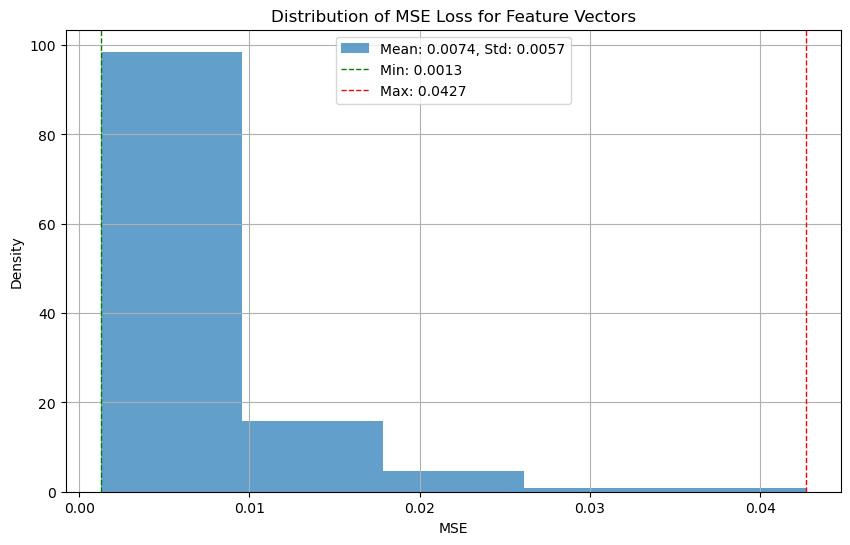

In [10]:
import torch
import matplotlib.pyplot as plt
import torch.nn as nn

# Assume train_day7_feats_minmaxed and train_day10_feats_minmaxed are already loaded
# Example shapes: [130, 512]

# Ensure the tensors are on the same device as the model

with torch.no_grad():
        train_day7_feats_minmaxed = train_day7_feats_minmaxed.to(device)
        train_day10_feats_minmaxed = train_day10_feats_minmaxed.to(device)

        predicted_day10 = model(train_day7_feats_minmaxed)

print(predicted_day10.shape)

# Initialize the MSE loss function
mse_loss_fn = nn.MSELoss(reduction='none')  # 'none' to get element-wise loss

# Compute the per-feature-vector MSE
mse_per_vector = mse_loss_fn(train_day10_feats_minmaxed, predicted_day10).mean(dim=1)  # Mean over feature dimension (512)

# Convert MSE values to a list for plotting
mse_values = mse_per_vector.cpu().numpy()

# Calculate statistics
mean_mse = mse_per_vector.mean().item()
std_mse = mse_per_vector.std().item()
min_mse = mse_per_vector.min().item()
max_mse = mse_per_vector.max().item()

# Plot the distribution of MSE values
plt.figure(figsize=(10, 6))
plt.hist(mse_values, bins=5, alpha=0.7, density=True, label=f"Mean: {mean_mse:.4f}, Std: {std_mse:.4f}")

# Add vertical lines for min and max
plt.axvline(min_mse, color='green', linestyle='--', linewidth=1, label=f"Min: {min_mse:.4f}")
plt.axvline(max_mse, color='red', linestyle='--', linewidth=1, label=f"Max: {max_mse:.4f}")

plt.title('Distribution of MSE Loss for Feature Vectors')
plt.xlabel('MSE')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
mse_values.shape

Mean MSE: 0.0074, Standard Deviation: 0.0057


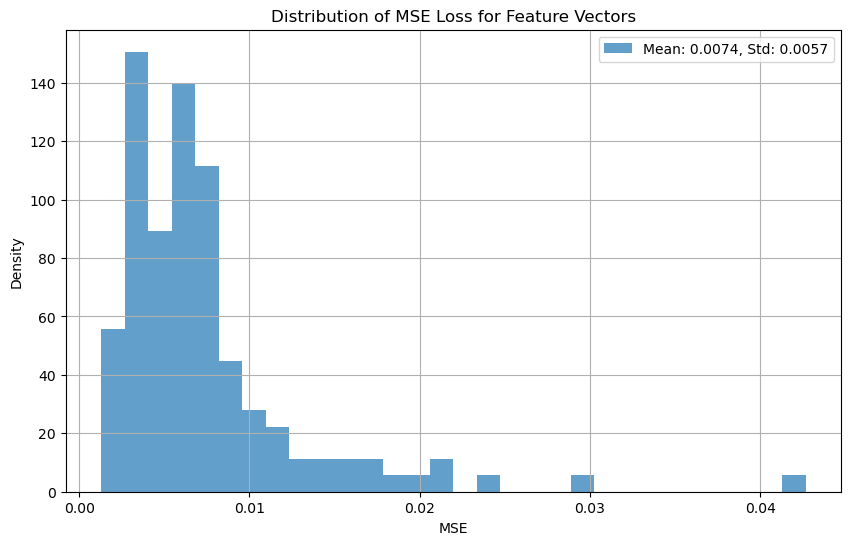

In [10]:
import torch
import matplotlib.pyplot as plt
import torch.nn as nn

# Assume train_day7_feats_minmaxed and train_day10_feats_minmaxed are already loaded
# Example shapes: [130, 512]

# Ensure the tensors are on the same device as the model
train_day7_feats_minmaxed = train_day7_feats_minmaxed.to(device)
train_day10_feats_minmaxed = train_day10_feats_minmaxed.to(device)

# Initialize the MSE loss function
mse_loss_fn = nn.MSELoss()

# List to store MSE for each feature vector
mse_values = []

# Loop through each feature vector
for i in range(train_day7_feats_minmaxed.shape[0]):
    train_day7_feat = train_day7_feats_minmaxed[i].unsqueeze(0)  # Shape: [1, 512]
    train_day10_feat = train_day10_feats_minmaxed[i].unsqueeze(0)  # Shape: [1, 512]
    
    # Get prediction
    with torch.no_grad():
        predicted_day10 = model(train_day7_feat)
    
    # Compute MSE for this feature vector
    mse = mse_loss_fn(predicted_day10, train_day10_feat).item()
    mse_values.append(mse)

# Convert MSE values to a tensor for statistical calculations
mse_values_tensor = torch.tensor(mse_values)

# Calculate mean and standard deviation
mean_mse = mse_values_tensor.mean().item()
std_mse = mse_values_tensor.std().item()

print(f"Mean MSE: {mean_mse:.4f}, Standard Deviation: {std_mse:.4f}")

# Plot the distribution of MSE values
plt.figure(figsize=(10, 6))
plt.hist(mse_values, bins=30, alpha=0.7, density=True, label=f"Mean: {mean_mse:.4f}, Std: {std_mse:.4f}")
plt.title('Distribution of MSE Loss for Feature Vectors')
plt.xlabel('MSE')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import torch
import matplotlib.pyplot as plt
import torch.nn as nn

# Assume train_day7_feats_minmaxed and train_day10_feats_minmaxed are already loaded
# Example shapes: [130, 512]

# Ensure the tensors are on the same device as the model
train_day7_feats_minmaxed = train_day7_feats_minmaxed.to(device)
train_day10_feats_minmaxed = train_day10_feats_minmaxed.to(device)

# Initialize the MSE loss function
mse_loss_fn = nn.MSELoss()

# List to store MSE for each feature vector
mse_values = []

# Loop through each feature vector
for i in range(train_day7_feats_minmaxed.shape[0]):
    train_day7_feat = train_day7_feats_minmaxed[i].unsqueeze(0)  # Shape: [1, 512]
    train_day10_feat = train_day10_feats_minmaxed[i].unsqueeze(0)  # Shape: [1, 512]
    
    # Get prediction
    with torch.no_grad():
        predicted_day10 = model(train_day7_feat)
    
    # Compute MSE for this feature vector
    mse = mse_loss_fn(predicted_day10, train_day10_feat).item()
    mse_values.append(mse)

# Convert MSE values to a tensor for statistical calculations
mse_values_tensor = torch.tensor(mse_values)

# Calculate mean and standard deviation
mean_mse = mse_values_tensor.mean().item()
std_mse = mse_values_tensor.std().item()

print(f"Mean MSE: {mean_mse:.4f}, Standard Deviation: {std_mse:.4f}")

# Plot the distribution of MSE values
plt.figure(figsize=(10, 6))
plt.hist(mse_values, bins=5, alpha=0.7, density=True, label=f"Mean: {mean_mse:.4f}, Std: {std_mse:.4f}")
plt.title('Distribution of MSE Loss for Feature Vectors')
plt.xlabel('MSE')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
#control trained
#torch.Size([130, 512])
#Mean MSE: 0.0074, Standard Deviation: 0.0057


#inference sd
#torch.Size([29, 512])
#Mean MSE: 0.0356, Standard Deviation: 0.0089



# inference

In [12]:
# Min-Max Scaling for Input (X) and Target (Y)
def min_max_scaling(data):
    data_min = data.min()
    data_max = data.max()
    return (data - data_min) / (data_max - data_min), data_min, data_max  # Return scaled data and min/max for inverse scaling

# Apply Min-Max Scaling
inference_sd_day7_minmaxed, day7_min, day7_max = min_max_scaling(inference_sd_day7)
inference_sd_day10_minmaxed, day10_min, day10_max = min_max_scaling(inference_sd_day10)
print(day7_min)
print(day7_max)
print(day10_min)
print(day10_max)
# Print summary to confirm
print("After Min-Max Scaling:")
print(f"Input (X): Min={inference_sd_day7_minmaxed.min():.4f}, Max={inference_sd_day7_minmaxed.max():.4f}")
print(f"Target (Y): Min={inference_sd_day10_minmaxed.min():.4f}, Max={inference_sd_day10_minmaxed.max():.4f}")



tensor(0.)
tensor(6.5900)
tensor(0.)
tensor(11.7951)
After Min-Max Scaling:
Input (X): Min=0.0000, Max=1.0000
Target (Y): Min=0.0000, Max=1.0000


torch.Size([29, 512])
Mean MSE: 0.0356, Standard Deviation: 0.0089
Min MSE: 0.0221, Max MSE: 0.0570
5


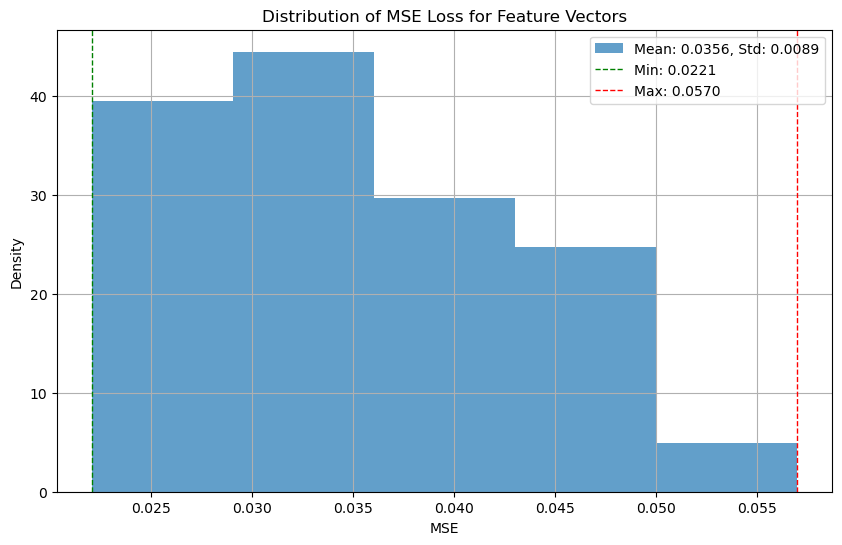

In [14]:
import torch
import matplotlib.pyplot as plt
import torch.nn as nn

# Assume inference_sd_day7_minmaxed and inference_sd_day10_minmaxed are already loaded and processed
with torch.no_grad():
    inference_sd_day7_minmaxed = inference_sd_day7_minmaxed.to(device)
    inference_sd_day10_minmaxed = inference_sd_day10_minmaxed.to(device)

    predicted_day10 = model(inference_sd_day7_minmaxed)

print(predicted_day10.shape)

# Initialize the MSE loss function
mse_loss_fn = nn.MSELoss(reduction='none')  # 'none' to get element-wise loss

# Compute the per-feature-vector MSE
mse_per_vector = mse_loss_fn(inference_sd_day10_minmaxed, predicted_day10).mean(dim=1)  # Mean over feature dimension (512)

# Convert MSE values to a list for plotting
mse_values = mse_per_vector.cpu().numpy()

# Calculate statistics
mean_mse = mse_per_vector.mean().item()
std_mse = mse_per_vector.std().item()
min_mse = mse_per_vector.min().item()
max_mse = mse_per_vector.max().item()

print(f"Mean MSE: {mean_mse:.4f}, Standard Deviation: {std_mse:.4f}")
print(f"Min MSE: {min_mse:.4f}, Max MSE: {max_mse:.4f}")

# Plot the distribution of MSE values
plt.figure(figsize=(10, 6))
import numpy as np

optimal_bins = int(np.sqrt(len(mse_values)))

print(optimal_bins)  # Calculate the number of bins based on the data size
plt.hist(mse_values, bins=optimal_bins, alpha=0.7, density=True, label=f"Mean: {mean_mse:.4f}, Std: {std_mse:.4f}")


# Add vertical lines for min and max
plt.axvline(min_mse, color='green', linestyle='--', linewidth=1, label=f"Min: {min_mse:.4f}")
plt.axvline(max_mse, color='red', linestyle='--', linewidth=1, label=f"Max: {max_mse:.4f}")

plt.title('Distribution of MSE Loss for Feature Vectors')
plt.xlabel('MSE')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()


torch.Size([29, 512])
Mean MSE: 0.0356, Standard Deviation: 0.0089
Min MSE: 0.0221, Max MSE: 0.0570


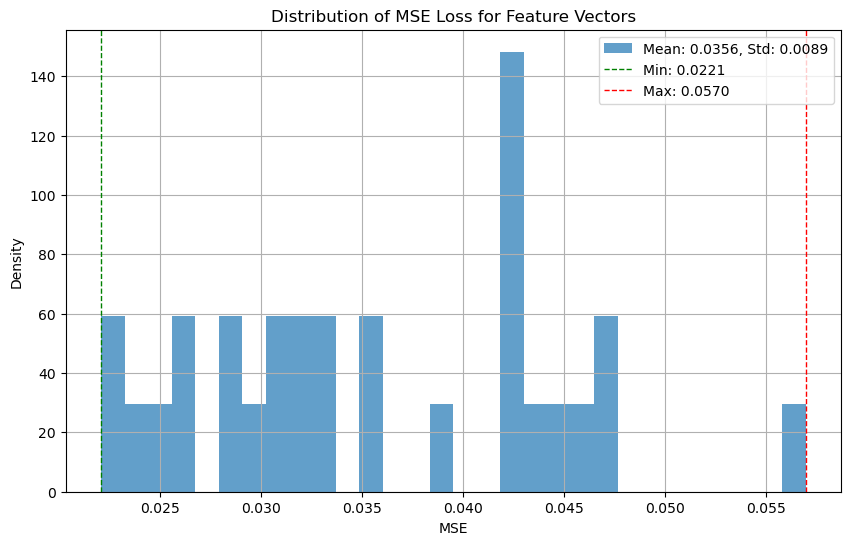

In [12]:
import torch
import matplotlib.pyplot as plt
import torch.nn as nn

# Assume inference_sd_day7_minmaxed and inference_sd_day10_minmaxed are already loaded and processed
with torch.no_grad():
    inference_sd_day7_minmaxed = inference_sd_day7_minmaxed.to(device)
    inference_sd_day10_minmaxed = inference_sd_day10_minmaxed.to(device)

    predicted_day10 = model(inference_sd_day7_minmaxed)

print(predicted_day10.shape)

# Initialize the MSE loss function
mse_loss_fn = nn.MSELoss(reduction='none')  # 'none' to get element-wise loss

# Compute the per-feature-vector MSE
mse_per_vector = mse_loss_fn(inference_sd_day10_minmaxed, predicted_day10).mean(dim=1)  # Mean over feature dimension (512)

# Convert MSE values to a list for plotting
mse_values = mse_per_vector.cpu().numpy()

# Calculate statistics
mean_mse = mse_per_vector.mean().item()
std_mse = mse_per_vector.std().item()
min_mse = mse_per_vector.min().item()
max_mse = mse_per_vector.max().item()

print(f"Mean MSE: {mean_mse:.4f}, Standard Deviation: {std_mse:.4f}")
print(f"Min MSE: {min_mse:.4f}, Max MSE: {max_mse:.4f}")

# Plot the distribution of MSE values
plt.figure(figsize=(10, 6))
plt.hist(mse_values, bins=30, alpha=0.7, density=True, label=f"Mean: {mean_mse:.4f}, Std: {std_mse:.4f}")

# Add vertical lines for min and max
plt.axvline(min_mse, color='green', linestyle='--', linewidth=1, label=f"Min: {min_mse:.4f}")
plt.axvline(max_mse, color='red', linestyle='--', linewidth=1, label=f"Max: {max_mse:.4f}")

plt.title('Distribution of MSE Loss for Feature Vectors')
plt.xlabel('MSE')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()


In [13]:
mse_values.shape

(29,)

import torch
import matplotlib.pyplot as plt
import torch.nn as nn

# Ensure the tensors are on the same device as the model

with torch.no_grad():
        inference_sd_day7_minmaxed = inference_sd_day7_minmaxed.to(device)
        inference_sd_day10_minmaxed = inference_sd_day10_minmaxed.to(device)

        predicted_day10 = model(inference_sd_day7_minmaxed)

print(predicted_day10.shape)

# Initialize the MSE loss function
mse_loss_fn = nn.MSELoss(reduction='none')  # 'none' to get element-wise loss

# Compute the per-feature-vector MSE
mse_per_vector = mse_loss_fn(inference_sd_day10_minmaxed, predicted_day10).mean(dim=1)  # Mean over feature dimension (512)

# Convert MSE values to a list for plotting
mse_values = mse_per_vector.cpu().numpy()

# Calculate statistics
mean_mse = mse_per_vector.mean().item()
std_mse = mse_per_vector.std().item()

print(f"Mean MSE: {mean_mse:.4f}, Standard Deviation: {std_mse:.4f}")

# Plot the distribution of MSE values
plt.figure(figsize=(10, 6))
plt.hist(mse_values, bins=30, alpha=0.7, density=True, label=f"Mean: {mean_mse:.4f}, Std: {std_mse:.4f}")
plt.title('Distribution of MSE Loss for Feature Vectors')
plt.xlabel('MSE')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()


Mean MSE: 0.0356, Standard Deviation: 0.0089
Min MSE: 0.0221, Max MSE: 0.0570


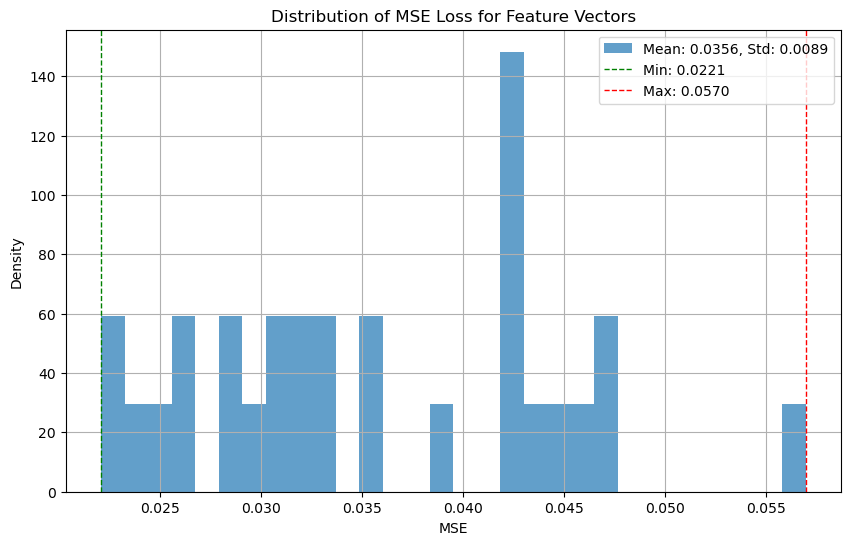

In [13]:
import torch
import matplotlib.pyplot as plt
import torch.nn as nn

# Ensure the tensors are on the same device as the model
inference_sd_day7_minmaxed = inference_sd_day7_minmaxed.to(device)
inference_sd_day10_minmaxed = inference_sd_day10_minmaxed.to(device)

# Initialize the MSE loss function
mse_loss_fn = nn.MSELoss()

# List to store MSE for each feature vector
mse_values = []

# Loop through each feature vector
for i in range(inference_sd_day7_minmaxed.shape[0]):
    inference_sd_day7 = inference_sd_day7_minmaxed[i].unsqueeze(0)  # Shape: [1, 512]
    inference_sd_day10 = inference_sd_day10_minmaxed[i].unsqueeze(0)  # Shape: [1, 512]
    
    # Get prediction
    with torch.no_grad():
        predicted_day10 = model(inference_sd_day7)
    
    # Compute MSE for this feature vector
    mse = mse_loss_fn(predicted_day10, inference_sd_day10).item()
    mse_values.append(mse)

# Convert MSE values to a tensor for statistical calculations
mse_values_tensor = torch.tensor(mse_values)

# Calculate mean, standard deviation, min, and max
mean_mse = mse_values_tensor.mean().item()
std_mse = mse_values_tensor.std().item()
min_mse = mse_values_tensor.min().item()
max_mse = mse_values_tensor.max().item()

print(f"Mean MSE: {mean_mse:.4f}, Standard Deviation: {std_mse:.4f}")
print(f"Min MSE: {min_mse:.4f}, Max MSE: {max_mse:.4f}")

# Plot the distribution of MSE values
plt.figure(figsize=(10, 6))
plt.hist(mse_values, bins=30, alpha=0.7, density=True, label=f"Mean: {mean_mse:.4f}, Std: {std_mse:.4f}")

# Add vertical lines for min and max values
plt.axvline(min_mse, color='green', linestyle='--', linewidth=1, label=f"Min: {min_mse:.4f}")
plt.axvline(max_mse, color='red', linestyle='--', linewidth=1, label=f"Max: {max_mse:.4f}")

plt.title('Distribution of MSE Loss for Feature Vectors')
plt.xlabel('MSE')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()


import torch
import matplotlib.pyplot as plt
import torch.nn as nn

# Assume train_day7_feats_minmaxed and train_day10_feats_minmaxed are already loaded
# Example shapes: [130, 512]

# Ensure the tensors are on the same device as the model
inference_sd_day7_minmaxed = inference_sd_day7_minmaxed.to(device)
inference_sd_day10_minmaxed = inference_sd_day10_minmaxed.to(device)

# Initialize the MSE loss function
mse_loss_fn = nn.MSELoss()

# List to store MSE for each feature vector
mse_values = []

# Loop through each feature vector
for i in range(inference_sd_day7_minmaxed.shape[0]):
    inference_sd_day7 = inference_sd_day7_minmaxed[i].unsqueeze(0)  # Shape: [1, 512]
    inference_sd_day10 = inference_sd_day10_minmaxed[i].unsqueeze(0)  # Shape: [1, 512]
    
    # Get prediction
    with torch.no_grad():
        predicted_day10 = model(inference_sd_day7)
    
    # Compute MSE for this feature vector
    mse = mse_loss_fn(predicted_day10, inference_sd_day10).item()
    mse_values.append(mse)

# Convert MSE values to a tensor for statistical calculations
mse_values_tensor = torch.tensor(mse_values)

# Calculate mean and standard deviation
mean_mse = mse_values_tensor.mean().item()
std_mse = mse_values_tensor.std().item()

print(f"Mean MSE: {mean_mse:.4f}, Standard Deviation: {std_mse:.4f}")

# Plot the distribution of MSE values
plt.figure(figsize=(10, 6))
plt.hist(mse_values, bins=30, alpha=0.7, density=True, label=f"Mean: {mean_mse:.4f}, Std: {std_mse:.4f}")
plt.title('Distribution of MSE Loss for Feature Vectors')
plt.xlabel('MSE')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()


In [11]:

# Perform inference
with torch.no_grad():
    # Ensure the input features are on the same device as the model
    inference_sd_day7_minmaxed = inference_sd_day7_minmaxed.to(device)
    inference_sd_day10_minmaxed = inference_sd_day10_minmaxed.to(device)
    
    # Predict the target (Day 10) from the input (Day 7)
    predicted_day10 = model(inference_sd_day7_minmaxed)

# Evaluate predictions (optional)
# If you have a target (e.g., inference_feat_day10_minmaxed), calculate MSE or another metric
mse_loss = nn.MSELoss()(predicted_day10, inference_sd_day10_minmaxed)
print(f"Mean Squared Error on Inference Data: {mse_loss.item():.4f}")

# Print or save the predictions
print("Predicted Target (Day 10 features):")
print(predicted_day10.cpu().numpy())
print(predicted_day10.shape)

Mean Squared Error on Inference Data: 0.0356
Predicted Target (Day 10 features):
[[ 0.03824107 -0.00809979  0.26290122 ...  0.19787881  0.0905065
   0.13490143]
 [ 0.13701724  0.04185124  0.18898141 ...  0.37782115  0.3402086
   0.38382533]
 [ 0.13669428  0.04162186  0.18533179 ...  0.3726402   0.33925337
   0.37942627]
 ...
 [ 0.1408076   0.04361168  0.19064978 ...  0.38572806  0.3474722
   0.3929438 ]
 [ 0.10590675  0.02734081  0.17735776 ...  0.30963027  0.2760213
   0.30296117]
 [ 0.14663166  0.04642853  0.19253469 ...  0.39802122  0.358813
   0.4065541 ]]
torch.Size([29, 512])


def train_and_evaluate(
    model, 
    train_loader, 
    val_loader, 
    criterion, 
    optimizer, 
    num_epochs=50, 
    device='cuda' if torch.cuda.is_available() else 'cpu'
):

    model = model.to(device)
    history = {'train_loss': [], 'val_loss': []}
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        for batch_inputs, batch_targets in train_loader:
            # Move data to the appropriate device
            batch_inputs, batch_targets = batch_inputs.to(device), batch_targets.to(device)
            
            # Forward pass
            outputs = model(batch_inputs)
            loss = criterion(outputs, batch_targets)
            train_loss += loss.item()
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        train_loss /= len(train_loader)
        history['train_loss'].append(train_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch_inputs, batch_targets in val_loader:
                # Move data to the appropriate device
                batch_inputs, batch_targets = batch_inputs.to(device), batch_targets.to(device)
                
                # Forward pass
                outputs = model(batch_inputs)
                loss = criterion(outputs, batch_targets)
                val_loss += loss.item()
        
        val_loss /= len(val_loader)
        history['val_loss'].append(val_loss)
        
        # Print epoch stats
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')
    
    return history



def cross_validate_and_train(
    model_class,  # Pass the class, not an instance
    dataset,
    criterion,
    optimizer_class,
    num_epochs=50,
    n_splits=5,
    device='cuda' if torch.cuda.is_available() else 'cpu'
):
    """
    Perform cross-validation and train the model on each fold.
    
    Args:
        model_class: The class of the model to train (not an instance).
        dataset: The dataset containing features and targets.
        criterion: The loss function.
        optimizer_class: The optimizer class (e.g., torch.optim.Adam).
        num_epochs: Number of epochs for each fold.
        n_splits: Number of cross-validation splits.
        device: Device to use for training ('cuda' or 'cpu').
        
    Returns:
        list: A list containing the history (losses) for each fold.
    """
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    histories = []
    
    for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset)):
        print(f"Fold {fold + 1}/{n_splits}")
        
        # Create subsets for this fold
        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)
        
        # Create DataLoaders
        train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)
        
        # Initialize the model and optimizer for this fold
        model = model_class().to(device)
        optimizer = optimizer_class(model.parameters(), lr=1e-4)
        
        # Train and evaluate for this fold
        history = train_and_evaluate(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            criterion=criterion,
            optimizer=optimizer,
            num_epochs=num_epochs,
            device=device
        )
        
        histories.append(history)
    
    return histories

dataset = TensorDataset(train_day7_feats, train_day10_feats)

# Perform cross-validation
cv_histories = cross_validate_and_train(
    model_class=FeaturePredictor,  # Pass the model class
    dataset=dataset,
    criterion=criterion,
    optimizer_class=torch.optim.Adam,
    num_epochs=1000,
    n_splits=5
)

import matplotlib.pyplot as plt

def plot_loss_curves(cv_histories, num_epochs):
    """
    Plot training and validation loss curves for each fold.
    
    Args:
        cv_histories (list): List of loss histories for each fold.
        num_epochs (int): Number of epochs.
    """
    plt.figure(figsize=(10, 6))

    for fold, history in enumerate(cv_histories):
        epochs = range(1, num_epochs + 1)
        plt.plot(epochs, history['train_loss'], label=f'Fold {fold + 1} Train Loss')
        plt.plot(epochs, history['val_loss'], label=f'Fold {fold + 1} Val Loss', linestyle='--')

    plt.title('Training and Validation Loss per Fold')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
plot_loss_curves(cv_histories, num_epochs=1000)


import matplotlib.pyplot as plt

def plot_loss_curves_separately(cv_histories, num_epochs):
    """
    Plot training and validation loss curves for each fold in separate figures.
    
    Args:
        cv_histories (list): List of loss histories for each fold.
        num_epochs (int): Number of epochs.
    """
    # Plot Training Loss
    plt.figure(figsize=(10, 6))
    for fold, history in enumerate(cv_histories):
        epochs = range(1, num_epochs + 1)
        plt.plot(epochs, history['train_loss'], label=f'Fold {fold + 1} Train Loss')
    plt.title('Training Loss per Fold')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot Validation Loss
    plt.figure(figsize=(10, 6))
    for fold, history in enumerate(cv_histories):
        epochs = range(1, num_epochs + 1)
        plt.plot(epochs, history['val_loss'], label=f'Fold {fold + 1} Val Loss', linestyle='--')
    plt.title('Validation Loss per Fold')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
plot_loss_curves_separately(cv_histories, num_epochs=1000)


# Average the training and validation losses across folds
avg_train_loss = np.mean([history['train_loss'][-1] for history in cv_histories])
avg_val_loss = np.mean([history['val_loss'][-1] for history in cv_histories])

print(f"Average Training Loss: {avg_train_loss:.4f}")
print(f"Average Validation Loss: {avg_val_loss:.4f}")
